In [2]:
import json
import csv
from helpers import *
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter, defaultdict
from scipy.stats import zscore, spearmanr, pearsonr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import colormaps
import datetime
import random
import os
import matplotlib.colors as mcolors
import re
from nltk.stem.wordnet import WordNetLemmatizer
import math

In [3]:
ROOT = '/data0/lucy/asian-american-textbooks/'
DATA = ROOT + 'data/'
LOGS = ROOT + 'logs/'
PEOPLE_TERMS = ROOT + 'wordlists/people_terms.csv'
CAL = ROOT + 'data/coref_resolved_ca/'
TEX = ROOT + 'data/coref_resolved_tx/'

# Data preprocessing

### Clean up text

We first manually stripped paratext from text, and ran `python clean_california.py` to stitch together sentences that were broken during the textbook digitization process for California textbooks. (Our Texas textbooks did not have this issue.) 

### Coref resolution

Then, we ran coreference resolution on the texts, borrowing a script from [Lucy & Demszky et al. AERA Open 2020](https://github.com/EduNLP/textbook-analysis). Note that spacy's coreference resolution pipeline (called neuralcoref) uses an older version of spacy than the rest of our book processing pipeline. To manage this difference, I suggest using different conda environments for spacy coref versus the other parts of this project. 

Example script calls: 

```python run_coref.py --input_dir data/clean_ca --output_dir data/coref_resolved_ca```

```python run_coref.py --input_dir data/source_txt_tx --output_dir data/coref_resolved_tx```

### Summary statistics

Word and sentence tokenization is performed using SpaCy's `en_core_web_trf` model, which requires a GPU. This is different from the small model in [Lucy & Demszky et al. AERA Open 2020](https://github.com/EduNLP/textbook-analysis), and it provides [better performance on multiple NLP tasks](https://spacy.io/models/en).

To get dataset statistics: 

```python dataset_statistics.py --input_dir data/coref_resolved_ca --output_prefix logs/ca```

```python dataset_statistics.py --input_dir data/coref_resolved_tx --output_prefix logs/tx```

In [3]:
def show_summary_counts(): 
    states = ['ca', 'tx']
    df_list = []
    for state in states: 
        this_df = pd.read_csv(LOGS + state + '_stats.csv')
        this_df = this_df.rename(columns={"Unnamed: 0": "Title"})
        this_df['State'] = state.upper()
        df_list.append(this_df)
    df = pd.concat(df_list)
    df = df[df.Title != 'OVERALL']
    return df

In [4]:
summary_df = show_summary_counts()
print("Total sentences in dataset:", summary_df['Sentences'].sum())
print("Total tokens in dataset:", summary_df['Tokens'].sum())
summary_df

Total sentences in dataset: 874125
Total tokens in dataset: 14441273


,Title,Sentences,Tokens,Unique Tokens,State
0,"America Through the Lens, U.S. History 1877 to...",22291,365694,19102,CA
1,"America, Pathways to the Present, Modern Ameri...",39820,541573,26301,CA
2,America_s History Concise Edition_ca,13532,357189,18369,CA
3,America_s History_ca,10074,276305,15482,CA
4,"American Anthem Modern American History, Calif...",31569,416087,19388,CA
5,American Journey_ca,25022,434147,25704,CA
6,American Odyssey_ca,6403,97455,10856,CA
7,American Vision_ca,20687,490809,25456,CA
8,"California, United States History, The Twentie...",23892,352430,17307,CA
9,"Give Me Liberty!, An American History, Volume ...",14148,276458,16231,CA


# Coverage of Asians / Asian-Americans

After running coreference resolution on the texts, I take the list of people terms and examine where asian and asian american (AA) words show up in each book.  

To get sentence locations of people in AA term list: 

```python people_location.py --input_dir data/coref_resolved_ca --output_prefix logs/ca --people_terms wordlists/people_terms.csv```

```python people_location.py --input_dir data/coref_resolved_tx --output_prefix logs/tx --people_terms wordlists/people_terms.csv```

To avoid double counting terms, I removed all terms in the wordlist of people that had one token that is also a token in another term, e.g. "asian-american" contains "asian" in it already, but kept terms that need to appear as bigrams or trigrams, e.g. "sri-lankan" and "indian-american" (counting them with and without the dash). 

Also, we only count "Indian" if it co-occurs with "Asian" in the same noun chunk since textbooks use outdated language to refer to Indians. 

The few bigrams and trigrams in the wordlist are: 
- Sri-Lankan, Sri Lankan

Using `grep` it does not seem like Sri Lankan terms appear in Californian or Texas books. *Indian American* appears once, but refers to Native Americans. 

In [5]:
# these are books that are multiple volumes that should be combined
combine_volume_dict = {'Give Me Liberty!, An American History, Volume 1_ca_2022':'Give Me Liberty!, An American History_ca', 
                          'Give Me Liberty!, An American History, Volume 2_ca_2022':'Give Me Liberty!, An American History_ca', 
                          'America_s History_ca':'America_s History combined_ca', 
                          'America_s History Concise Edition_ca':'America_s History combined_ca', 
                          'The American People Concise Edition Vol 2_ca':'The American People combined_ca', 
                          'The American People_ca':'The American People combined_ca'}

In [6]:
aa_terms, other_terms = get_people_terms(PEOPLE_TERMS)

In [7]:
ca_books = get_book_txts(CAL, splitlines=True)
tx_books = get_book_txts(TEX, splitlines=True)

Getting books from /data0/lucy/asian-american-textbooks/data/coref_resolved_ca/
Finished getting books.
Getting books from /data0/lucy/asian-american-textbooks/data/coref_resolved_tx/
Finished getting books.


In [8]:
def count_sentences_that_contain_aa(): 
    total = 0
    print("TEXAS")
    for title in tx_books: 
        with open(ROOT + 'logs/tx_term_locations/' + title + '.json', 'r') as infile: 
            d = json.load(infile)
        sentence_ids = set()
        for term in d: 
            sentence_ids.update(d[term])
        print(len(sentence_ids), title)
        total += len(sentence_ids)
    print()
    print("CALIFORNIA")
    for title in ca_books: 
        with open(ROOT + 'logs/ca_term_locations/' + title + '.json', 'r') as infile: 
            d = json.load(infile)
        sentence_ids = set()
        for term in d: 
            sentence_ids.update(d[term])
        print(len(sentence_ids), title)
        total += len(sentence_ids)
    print()
    print("---- TOTAL # of AA SENTENCES:", total)
    
count_sentences_that_contain_aa()

TEXAS
323 America_A_Narrative_History_WWNorton_10th (1)
296 America_Past_And_Present_Pearson_10th (1)
349 Americas_History_Bedford_8th (1)
286 Give_Me_Liberty_An_American_History_WWNorton_3rd (1)
336 The_American_Pageant_Cengage_14th (1)
320 The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th (1)
448 Visions_of_America_A_History_of_the_United_States_Pearson_2nd (1)
440 american_history_connecting_with_the_past (1)
340 by_the_people (1)
104 history_alive_united_states_thru_industrialism (1)
406 hmh_the_americans_us_history_since_1877 (1)
190 mastering_the_teks (1)
417 pearson_us_history (1)
293 teks_us_history (1)
18 us_history_early_colonial_period_through_reconstruction (1)

CALIFORNIA
417 America Through the Lens, U.S. History 1877 to the Present, California Edition_ca_2022
450 America, Pathways to the Present, Modern American History_ca_2022
309 America_s History Concise Edition_ca
33 America_s History_ca
466 American Anthem Modern American History, Califo

In [9]:
def generate_frequency_chart(): 
    data = {
        'Textbook': [], 
        'State': [], 
        'Proportion': [],
        'Social Group': [],
    }
    ca_totals = defaultdict(Counter)
    tx_totals = defaultdict(Counter)
    all_totals = Counter()
    for title in ca_books: 
        with open(ROOT + 'logs/ca_term_locations/' + title + '.json', 'r') as infile: 
            d = json.load(infile)
        # combine multivolume
        if title in combine_volume_dict: 
            title = combine_volume_dict[title]
        for term in d: 
            if term.endswith('s'): 
                ca_totals[title][term[:-1]] += len(d[term])
                all_totals[term[:-1]] += len(d[term])
            else: 
                ca_totals[title][term] += len(d[term])
                all_totals[term] += len(d[term])
    for title in tx_books: 
        with open(ROOT + 'logs/tx_term_locations/' + title + '.json', 'r') as infile: 
            d = json.load(infile)
        if title in combine_volume_dict: 
            title = combine_volume_dict[title]
        for term in d: 
            if term.endswith('s'): 
                tx_totals[title][term[:-1]] += len(d[term])
                all_totals[term[:-1]] += len(d[term])
            else: 
                tx_totals[title][term] += len(d[term])
                all_totals[term] += len(d[term])
    for title in ca_totals: 
        title_sum = sum(list(ca_totals[title].values()))
        for term in all_totals: 
            data['Textbook'].append(title)
            data['State'].append('CA')
            data['Proportion'].append(ca_totals[title][term] / title_sum)
            data['Social Group'].append(term)
    for title in tx_totals: 
        title_sum = sum(list(tx_totals[title].values()))
        for term in all_totals:
            data['Textbook'].append(title)
            data['State'].append('TX')
            data['Proportion'].append(tx_totals[title][term] / title_sum)
            data['Social Group'].append(term)
        
    df = pd.DataFrame(data)
    mean_prop = Counter(df.groupby('Social Group').mean('Proportion').to_dict()['Proportion'])
    order = [tup[0] for tup in mean_prop.most_common()]
    
    plt.figure(figsize=(15,5), dpi=300)
    colors = sns.color_palette()
    ax = sns.barplot(x="Social Group", y="Proportion", data=df, order=order, color=colors[0])
    plt.xticks(rotation=30)
    plt.show() 
    
    data = {
        'Proportion': [],
        'Social Group': [],
    }
    total_sum = sum(list(all_totals.values()))
    for term in all_totals: 
        data['Proportion'].append(all_totals[term] / total_sum)
        data['Social Group'].append(term)
    df = pd.DataFrame(data)
    mean_prop = Counter(df.groupby('Social Group').mean('Proportion').to_dict()['Proportion'])
    order = [tup[0] for tup in mean_prop.most_common()]
    
    plt.figure(figsize=(15,5), dpi=300)
    colors = sns.color_palette()
    ax = sns.barplot(x="Social Group", y="Proportion", data=df, order=order, color=colors[0])
    plt.xticks(rotation=30, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Proportion", fontsize=20)
    plt.xlabel("Social Group", fontsize=20)
    plt.show() 
    
def calculate_mean_variance(): 
    state_books_list = [ca_books, tx_books]
    path_list = [ROOT + 'logs/ca_term_locations/', ROOT + 'logs/tx_term_locations/']
    
    totals = Counter()
    for i, state_books in enumerate(state_books_list):
        path = path_list[i]
        for title in state_books: 
            total = 0
            with open(path + title + '.json', 'r') as infile: 
                d = json.load(infile)
            if title in combine_volume_dict: 
                title = combine_volume_dict[title]
            for term in d: 
                total += len(d[term])
            totals[title] = total
        for tup in totals.most_common(): 
            print(str(tup[1]) + '\t' + tup[0])
    print()
    print("STANDARD DEVIATION:", np.std(list(totals.values())))
    print("MEAN:", np.mean(list(totals.values())))
    print()

### AA word counts per state

In this chart, I combine counts for plural and singular forms of words, e.g. *korean* + *koreans*.

The top plot below has confidence intervals because it averages proportions for each textbook, while the bottom version is the exact proportion of all sentences across textbooks. We use the bottom plot for **Figure 1** in our paper. 

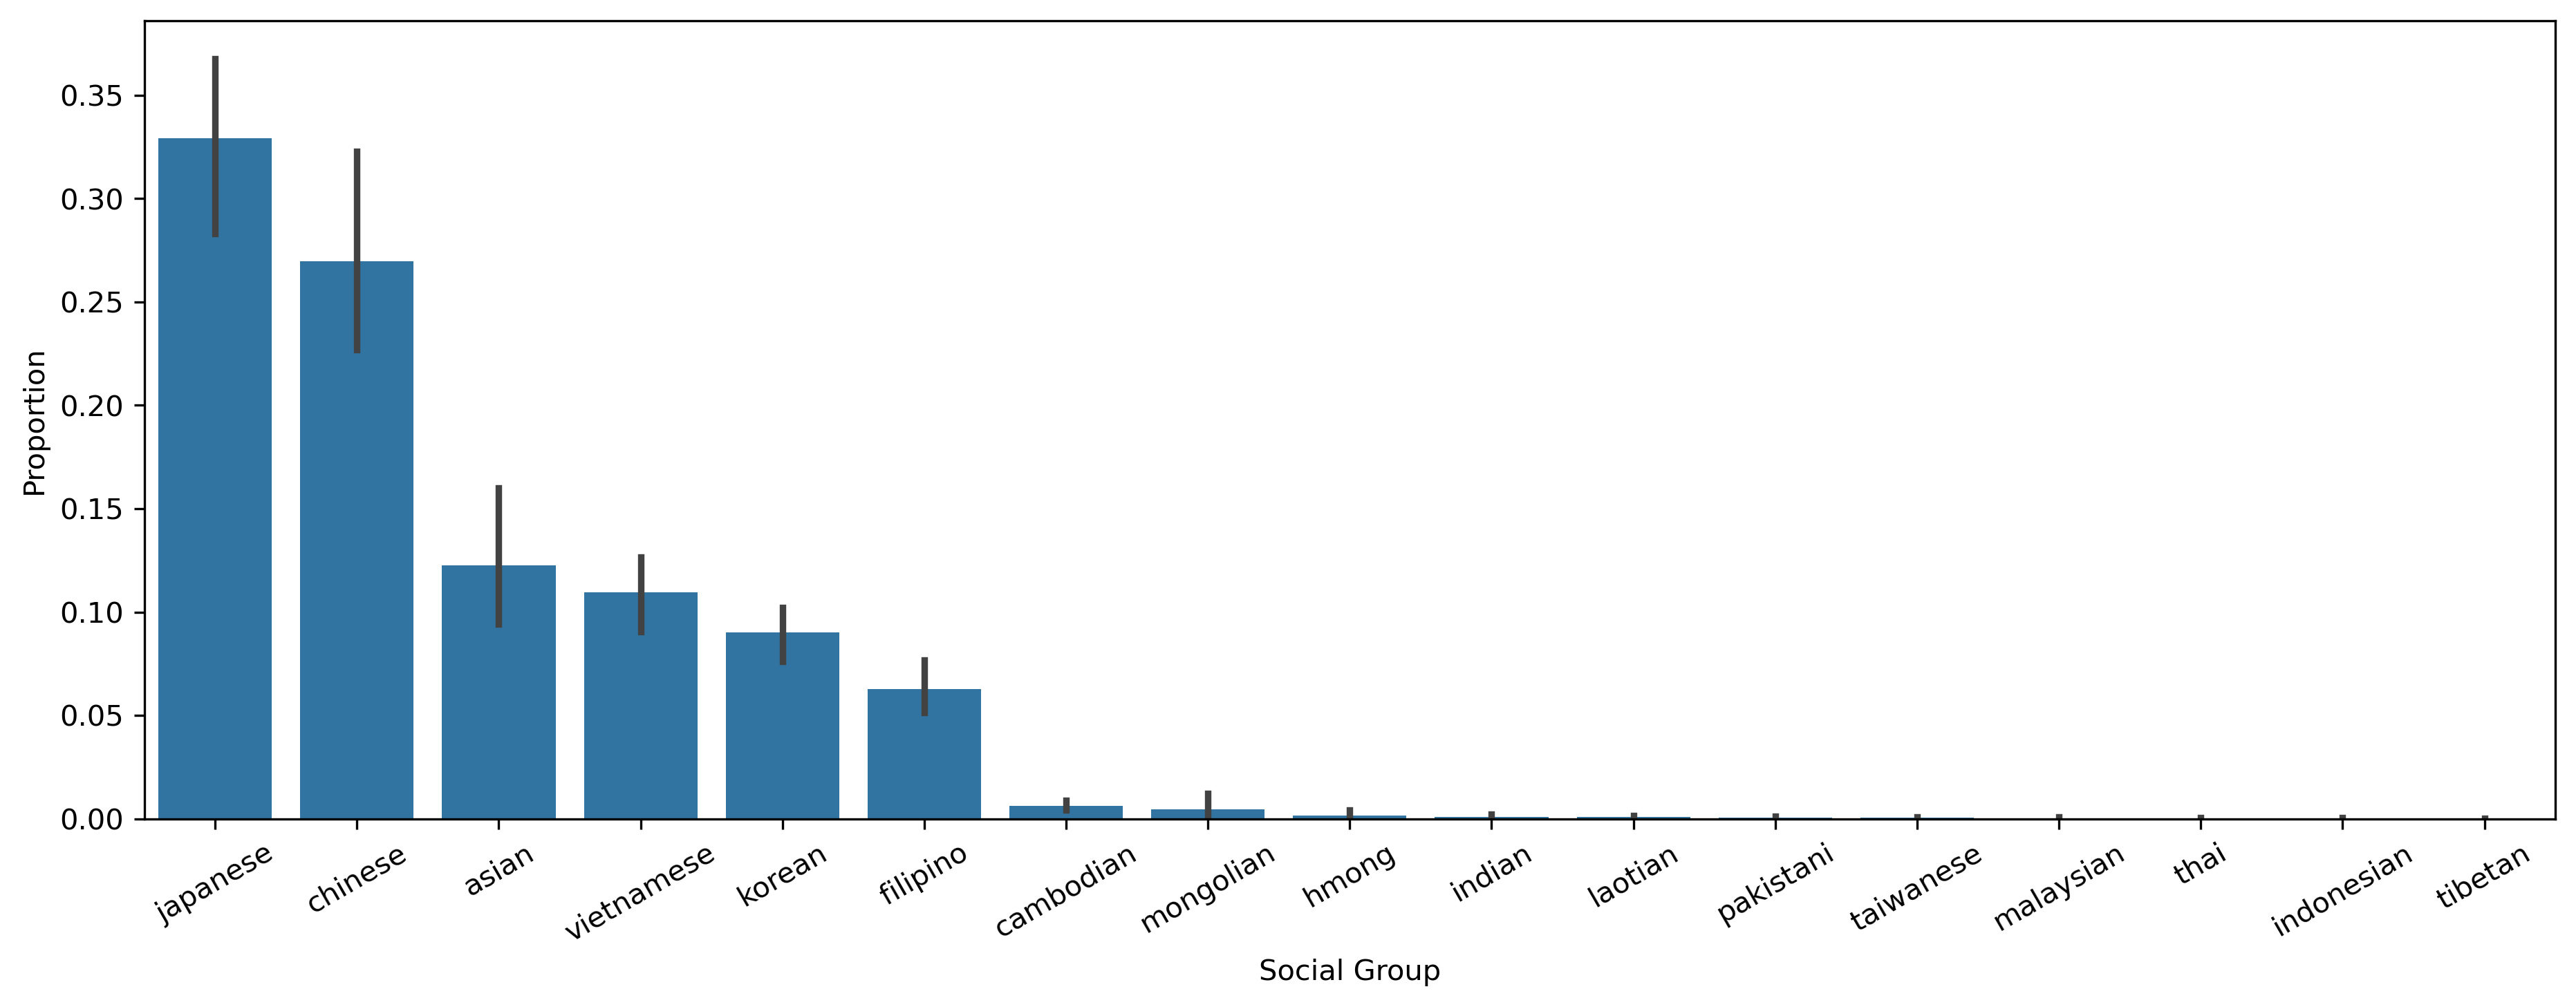

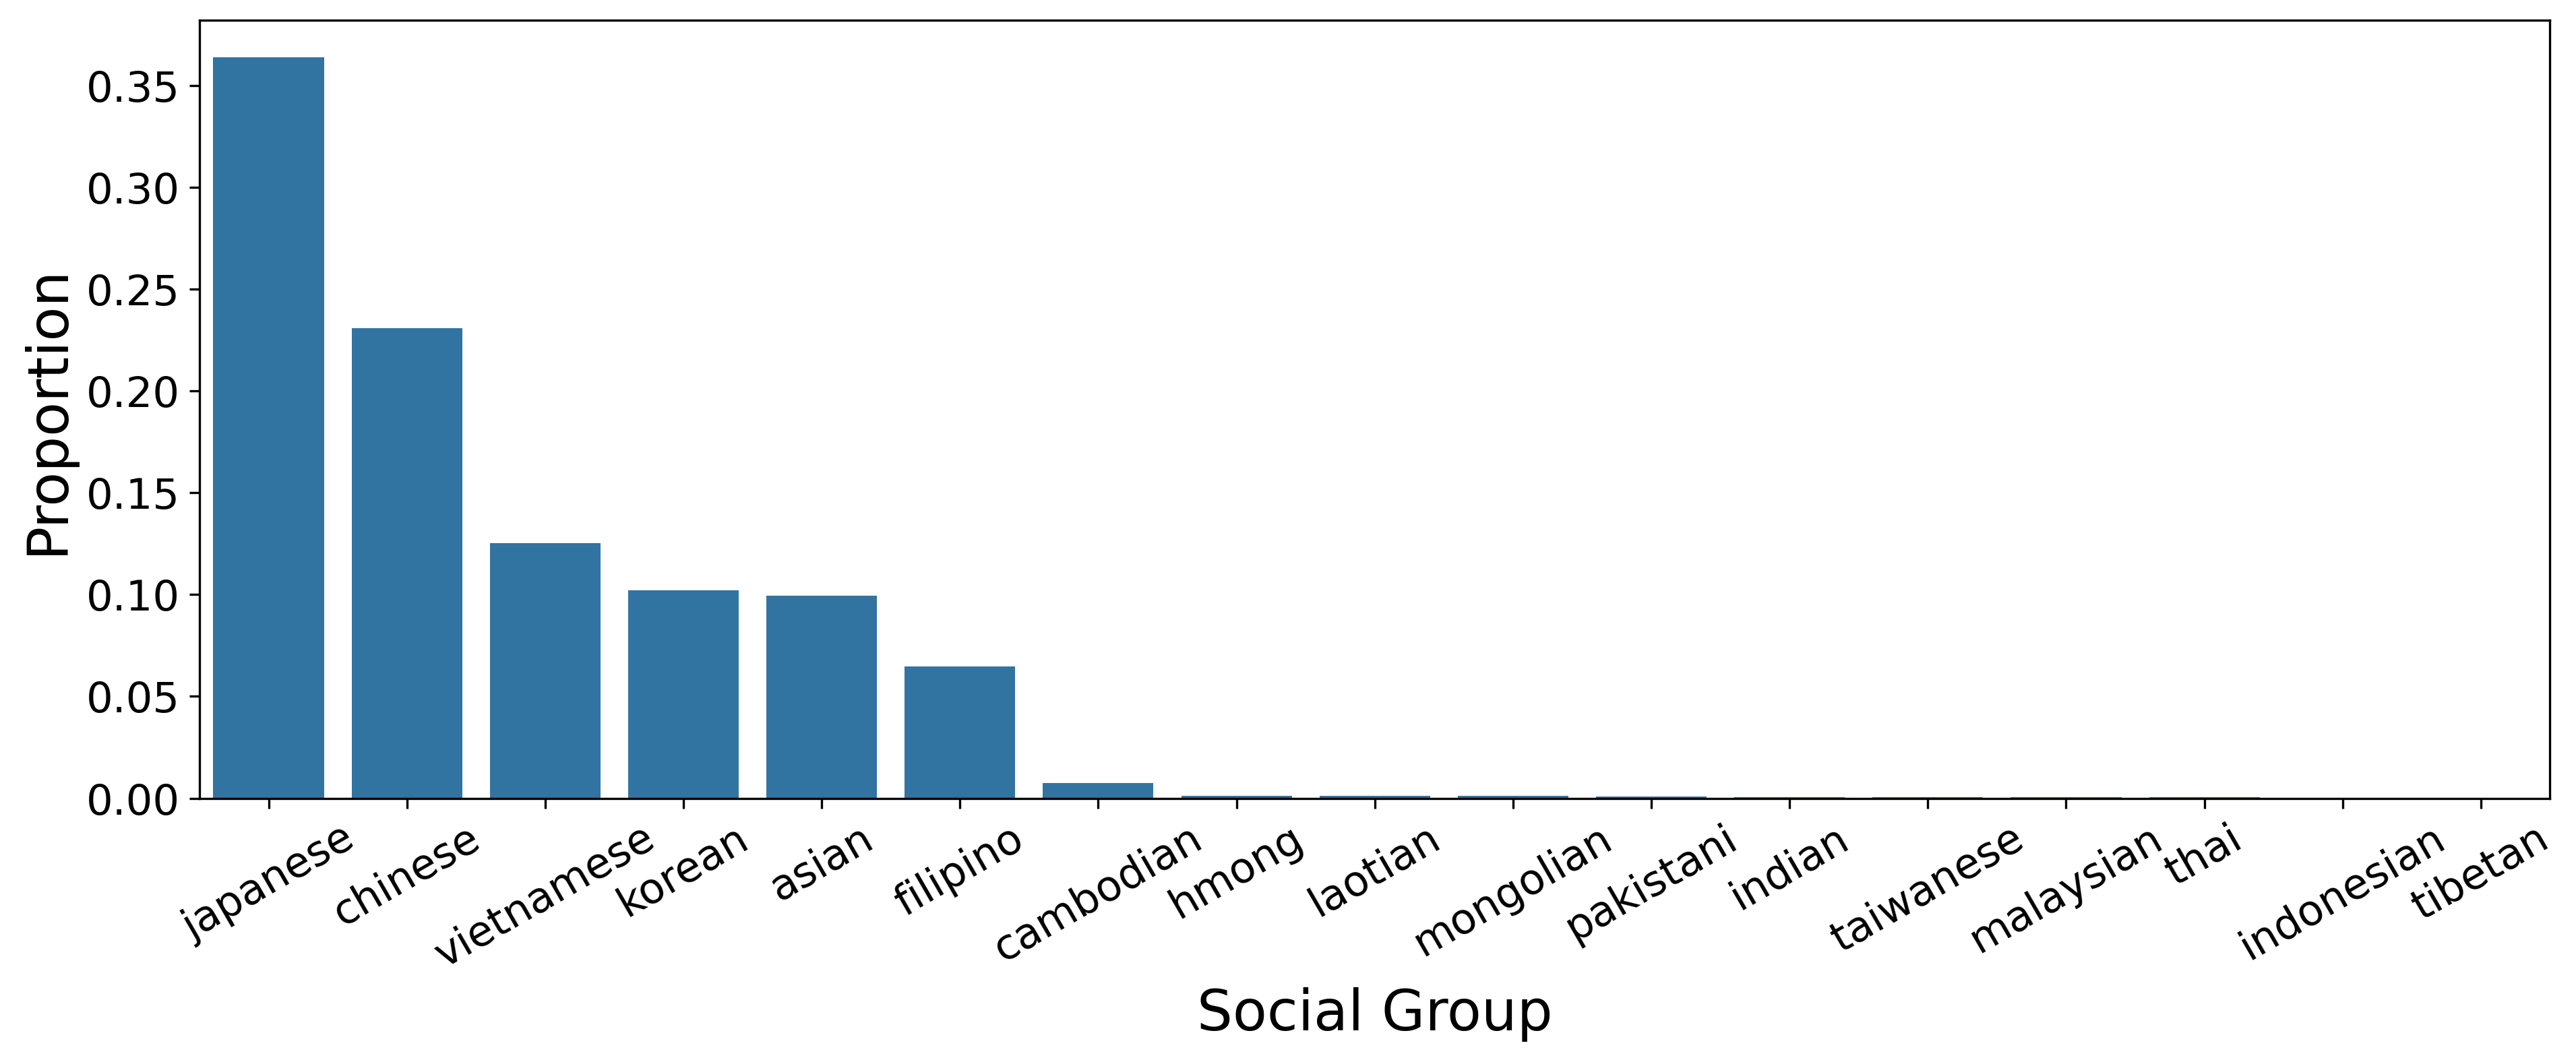

In [10]:
generate_frequency_chart()

### Total AA word counts per book

Within states, there is large variance and range in how often Asians are mentioned in textbooks. The first column is the number of mentions, and the second is the filename of the textbook. 

Some of the books with few Asian Americans focus on the first half of history. 

In [11]:
calculate_mean_variance()

477	America, Pathways to the Present, Modern American History_ca_2022
476	American Anthem Modern American History, California Edition (HRW Modern American History) RINEHART AND WINSTON HOLT_CL_hyp
440	The Americans Reconstruction to the 21st Century_ca
433	America Through the Lens, U.S. History 1877 to the Present, California Edition_ca_2022
399	American Vision_ca
373	California, United States History, The Twentieth Century_ca_2022
363	Prentice Hall, United States History, Modern America_ca_2022
269	United States History and Geography, Student Edition (UNITED STATES HISTORY (HS)) McGraw Hill_CL_hyp
235	American Journey_ca
222	Give Me Liberty!, An American History_ca
112	American Odyssey_ca
60	United States History Independence to 1914_CL_hyp
35	America_s History combined_ca
32	The American People combined_ca
9	The Unfinished Nation Vol 1_ca
483	Visions_of_America_A_History_of_the_United_States_Pearson_2nd (1)
477	America, Pathways to the Present, Modern American History_ca_2022
476	Ame

### Named individuals

In [16]:
def show_most_common_names(): 
    names = Counter()
    for title in ca_books: 
        with open(ROOT + 'logs/ca_names/' + title + '.json', 'r') as infile: 
            book_names = json.load(infile)
        names.update(book_names)
    print()
    for title in tx_books: 
        with open(ROOT + 'logs/tx_names/' + title + '.json', 'r') as infile: 
            book_names = json.load(infile)
        names.update(book_names)
    unique_names = set(names.keys())
    print()
    print("TOTAL UNIQUE NAMES:", len(unique_names))
    for name in unique_names: 
        print(name)
    return names
name_counts = show_most_common_names()



TOTAL UNIQUE NAMES: 438
William Calley
Chi Minh's
Harry Truman
Carl Schurz
John W. Dower
Marshall
Matsunaga
Shaw
Robert Kennedy
Robert McNamara
Al Fossett
Carter
Yehenara
Saddam Hussein
Zheng He
Dennis Kearney
Henry Cabot Lodge
Christ
Yamamoto
Daniel K. Inouye
Juan Ponce de León
George Hoar
Fred Korematsu
Gerald Ford
Joseph Stalin
James A. Wales
Ky
Matthew B. Ridgway
Hirol
LeMay
Westmoreland
Harris
Chun Duck Chin
Mine Okubo
Hideki Tōjō
Curtis Lemay
Fred Korematsu's
Pang Houa's
Toyo Miyatake
Takao Ozawa
Zion Clmrch
Pol Pot
Zhu Di
Kim Il-Sung
Wong Kim Ark
the Lady of Cofachiqui
Henry Kissinger's
Le Thanh
Clemenceau
Norman Y. Mineta
Ngo Dinh Diem's
Bhagat Singh Thind
HOH CHEE MIHN
Yosuke Yamahata
Ellsberg
Zhou Enlai
Albert Johnson
Cixi
Humphrey
Sihanouk
James Madison's
My Lai
William L. "Rusty" Calley
Theodore Roosevelt’s
Seward
Wilson
Kim Dae-jung
Jiang Jieshi
Maya Angelou
MacArtlrnr
Frank Knox
Johnson Vietnamese
James Bryce
Hiran1 Leong Fong
John Calvin
HIDEKI TOJO
John Jeong
Gromyko


Then, we hand-annotate the occupation/role, national/ethnic origin, and race of each named entity. For Asians, we note whether they are only in foreign contexts, or also in American contexts (e.g. immigrants, refugees, and American-born Asians). 

In [17]:
white_count = 0
asian_count = 0
total = 0
white_military_gov = 0
foreign_asian_military_gov = 0
asian_us = 0
seen_names = set()
with open(DATA + 'asian_annotated_names.csv', 'r') as infile: 
    reader = csv.DictReader(infile)
    for row in reader:
        seen_names.add(row['Entity'])
        race = row['Race'].lower()
        role = row['Occupation/role in history'].lower()
        if race == 'white':
            # this excludes mixed-race "White"
            white_count += name_counts[row['Entity']]
            if 'politician' in role or 'military' in role or 'government' in role: 
                white_military_gov += name_counts[row['Entity']]
        if 'asian' in race: 
            asian_count += name_counts[row['Entity']]
            if ('politician' in role or 'military' in role or 'government' in role) and \
                row['If Asian, in U.S.?'] == 'No': 
                foreign_asian_military_gov += name_counts[row['Entity']]
            if row['If Asian, in U.S.?'] == 'Yes': 
                asian_us += name_counts[row['Entity']]
        total += name_counts[row['Entity']]
assert set(name_counts.keys()) - seen_names == set()
print("TOTAL:", total)
print("White fraction:", white_count / total)
print("\tWhite military/gov, out of total white:", white_military_gov / white_count)
print("Asian fraction:", asian_count / total)
print("\tAsian foreign military/gov, out of total asian:", foreign_asian_military_gov / asian_count)
print("\tAsian in U.S., out of total asian:", asian_us / asian_count)
print("\tAsian in U.S., out of total:", asian_us / total)

TOTAL: 1581
White fraction: 0.6419987349778621
	White military/gov, out of total white: 0.8975369458128079
Asian fraction: 0.29791271347248577
	Asian foreign military/gov, out of total asian: 0.7388535031847133
	Asian in U.S., out of total asian: 0.24628450106157113
	Asian in U.S., out of total: 0.07337128399746995


Below is how we generate **Figure 2** in the paper. 

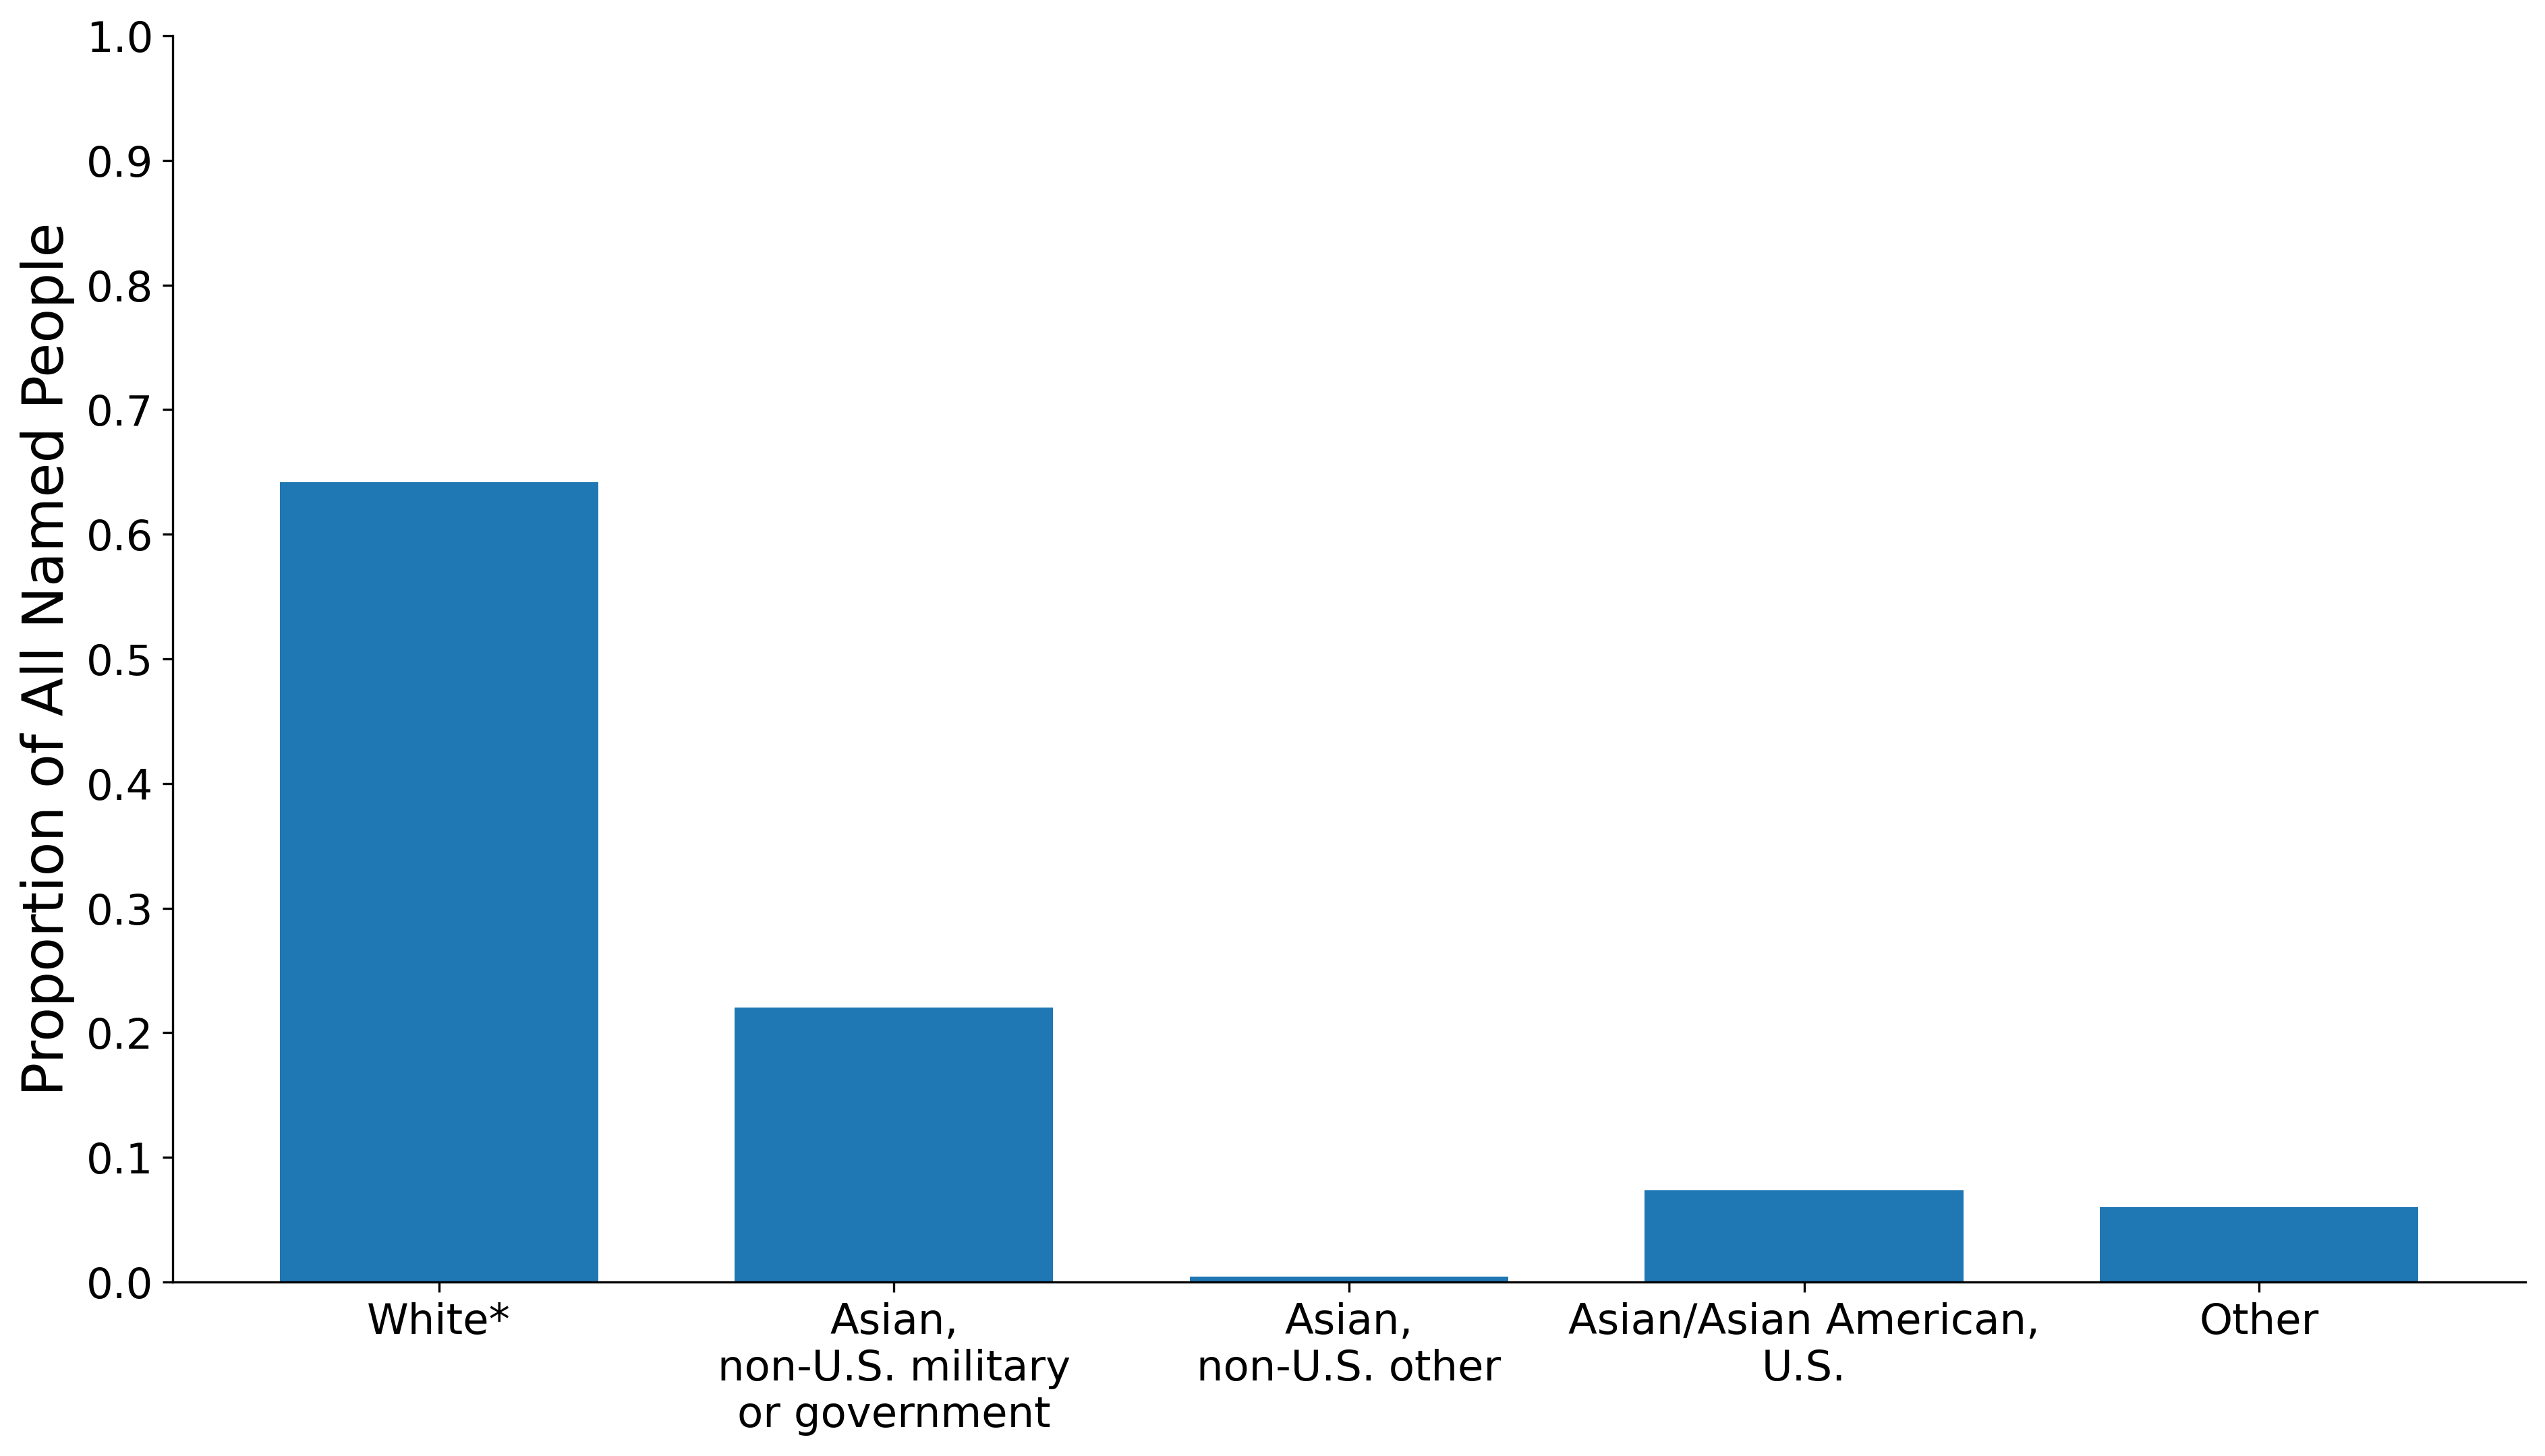

In [18]:
# plot showing two bars: white (split into military/gov and other), asian (split into non-U.S. military/gov, in the U.S.)
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(15, 8), dpi=300)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

other_asian = asian_count - foreign_asian_military_gov - asian_us
all_other = total - asian_count - white_count
cmap = colormaps.get_cmap('tab20c')
ax.bar(['White*', 'Asian,\nnon-U.S. military\nor government', 'Asian,\nnon-U.S. other', 'Asian/Asian American,\nU.S.', 'Other'], 
       [white_count / total, foreign_asian_military_gov / total, other_asian / total, asian_us / total, all_other / total], 0.7)
plt.ylabel("Proportion of All Named People", fontsize=20)
plt.xticks(fontsize=15)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=15)
plt.show()

# Description of Asians / Asian Americans

First, get descriptors all terms referring to people:

```python get_descriptors.py --input_dir data/coref_resolved_ca --output_prefix results/ca --people_terms wordlists/people_terms.csv```

```python get_descriptors.py --input_dir data/coref_resolved_tx --output_prefix results/tx --people_terms wordlists/people_terms.csv```

The above version differs from [Lucy & Demszky et al. AERA Open 2020](https://github.com/EduNLP/textbook-analysis) in that it uses noun phrases to handle adjectival modifiers that are bigrams or trigrams, e.g. "chinese-american community" or "chinese american community". For every noun phrase, we check if the head of the phrase is a person, and then check if an AA term appears in the phrase. Then we get the verb attached to the head of the phrase. 

In [23]:
ca_descript_df = pd.read_csv(ROOT + 'results/ca_people_descriptors.csv')
tx_descript_df = pd.read_csv(ROOT + 'results/tx_people_descriptors.csv')

In [24]:
ca_descript_df.head()

,token_ID,filename,entity,category,word,POS,rel
0,20,"America Through the Lens, U.S. History 1877 to...",you,other,carry,VERB,dobj
1,54,"America Through the Lens, U.S. History 1877 to...",you,other,think,VERB,nsubj
2,64,"America Through the Lens, U.S. History 1877 to...",europeans,other,encountered,VERB,nsubj
3,66,"America Through the Lens, U.S. History 1877 to...",europeans,other,arrived,VERB,nsubj
4,71,"America Through the Lens, U.S. History 1877 to...",the earliest humans,other,experienced,VERB,nsubj


In [25]:
tx_descript_df.head()

,token_ID,filename,entity,category,word,POS,rel
0,16,America_A_Narrative_History_WWNorton_10th (1),the native peoples,other,occupied,VERB,nsubj
1,24,America_A_Narrative_History_WWNorton_10th (1),everyone,other,came,VERB,nsubj
2,42,America_A_Narrative_History_WWNorton_10th (1),native american peoples,other,developed,VERB,nsubj
3,43,America_A_Narrative_History_WWNorton_10th (1),highly sophisticated societies,other,developed,VERB,dobj
4,46,America_A_Narrative_History_WWNorton_10th (1),others,other,focused,VERB,nsubj


In [29]:
def get_lexicon_vocabs(): 
    agency_power_vocab = set(agencies.keys())
    # conn_vocab is defined in next cell
    return agency_power_vocab
    
def get_verb_coverage(): 
    descript_df_list = [ca_descript_df, tx_descript_df]
    state_list = ['ca', 'tx']
    
    df = pd.concat(descript_df_list)

    agency_power_vocab = get_lexicon_vocabs()
    aa_df = df[df['category'] == 'aapi']
    verbs = aa_df[aa_df['POS'] == 'VERB']['word'].to_list()
    print("Total verbs:", len(verbs))
    verbs = [WordNetLemmatizer().lemmatize(v, 'v') for v in verbs]

    ap_coverage = [v for v in verbs if v in agency_power_vocab]
    no_ap_coverage = Counter([v for v in verbs if v not in agency_power_vocab])
    print("\nEXAMPLE OF MISSING:", no_ap_coverage.most_common(20))
    print("COVERAGE:", len(ap_coverage))
    print("VERB AGENCY POWER COVERAGE:", round(len(ap_coverage)*100/len(verbs), 2), "%")

    conn_coverage = [v for v in verbs if v in conn_vocab]
    no_conn_coverage = Counter([v for v in verbs if v not in conn_vocab])
    print("\nEXAMPLE OF MISSING:", no_conn_coverage.most_common(20))
    print("COVERAGE:", len(conn_coverage))
    print("VERB SENTIMENT COVERAGE:", round(len(conn_coverage)*100/len(verbs), 2), "%")

    verb_counts = Counter(verbs)
    print("\n--- MOST COMMON VERBS ---")
    for tup in verb_counts.most_common(10): 
        print(tup[0], tup[1])
    
'''
The following functions are copied from 
https://github.com/EduNLP/textbook-analysis/blob/master/get_lexicon_averages.py
'''
def get_ap_lexicon(): 
    '''
    @output: 
    - Two dictionaries of format {word : annotation}
    '''
    lexicon = './wordlists/agency_power.csv'
    agencies = {}
    powers = {}
    with open(lexicon, 'r') as infile:
        reader = csv.DictReader(infile)
        for row in reader:
            word = WordNetLemmatizer().lemmatize(row['verb'], 'v')
            if row['agency'] == 'agency_pos': 
                agencies[word] = 1
            elif row['agency'] == 'agency_neg': 
                agencies[word] = -1
            else: 
                agencies[word] = 0
            if row['power'] == 'power_agent': 
                powers[word] = 1
            elif row['power'] == 'power_theme': 
                powers[word] = -1
            else: 
                powers[word] = 0
    return (agencies, powers)

def get_conn_lexicon(): 
    '''
    @output: 
    - A dictionary of format {measurement : {word : score}}
    '''
    lexicon = './wordlists/full_frame_info.txt'
    ret = defaultdict(dict)
    vocab = set()
    with open(lexicon, 'r') as infile:
        reader = csv.DictReader(infile, delimiter="\t")
        for row in reader:
            vocab.add(row['verb'])
            for key in row: 
                if key != 'verb':
                    ret[key][row['verb']] = float(row[key])
    return (ret, vocab)

In [30]:
agencies, powers = get_ap_lexicon()
conn_lexicon, conn_vocab = get_conn_lexicon()

### Lexicon coverage of verbs and adjectives

We want to see how many verbs are being left out of our sentiment, power, and agency analysis using these static lexicons. Power and agency are part of the same dataset, and we get pretty good coverage. Sentiment coverage is a tad lower, which suggests if we wanted, we could induce labels for those. 

In our paper, we only report results from this section for sentiment. 

In [31]:
get_verb_coverage()

Total verbs: 3674

EXAMPLE OF MISSING: [('intern', 19), ('christianize', 14), ('massacre', 13), ('migrate', 10), ('overrun', 10), ('rebel', 10), ('outnumber', 9), ('segregate', 8), ('imprison', 7), ('perish', 6), ('pressure', 6), ('repel', 6), ('civilize', 6), ('relocate', 5), ('stag', 5), ('decipher', 5), ('ambush', 5), ('immigrate', 4), ('annex', 4), ('oust', 4)]
COVERAGE: 3353
VERB AGENCY POWER COVERAGE: 91.26 %

EXAMPLE OF MISSING: [('face', 33), ('intern', 19), ('do', 14), ('christianize', 14), ('massacre', 13), ('battle', 12), ('bomb', 12), ('agree', 11), ('retreat', 11), ('migrate', 10), ('overrun', 10), ('rebel', 10), ('saw', 9), ('outnumber', 9), ('sink', 8), ('segregate', 8), ('recruit', 7), ('compete', 7), ('imprison', 7), ('conquer', 7)]
COVERAGE: 3065
VERB SENTIMENT COVERAGE: 83.42 %

--- MOST COMMON VERBS ---
fight 87
attack 83
have 78
force 68
kill 67
take 52
drive 50
launch 45
begin 42
push 36


Now, we calculate verb lexicon scores for each group: 

In [32]:
def calculate_scores(input_file_list, agencies, powers, conn_lexicon, conn_vocab, 
                     input_stats=None, z_score=True, separate_cat=None): 
    '''
    The outputs of this function are dictionaries that are formatted
    in a way so that they can be easily transformed into pandas dataframes
    if needed. 
    - input_stats: optional argument that should be a tuple of (mean, stds)
    '''
    agen_d = {'Category' : [], 'Raw Value': [], 'Word' : []}
    power_d = {'Category' : [], 'Raw Value': [], 'Word' : []}
    sent_d = {'Category' : [], 'Raw Value': [], 'Word' : []}
    
    for input_file in input_file_list: 
        with open(input_file, 'r') as infile: 
            reader = csv.DictReader(infile)
            for row in reader: 
                ID = row['token_ID']
                title = row['filename']
                category = row['category']
                entity = row['entity']
                if separate_cat: 
                    for s in separate_cat: 
                        if s in entity: 
                            category = 'Separate'
                            break
                if category == 'other': 
                    category = 'Others'
                if category == 'aapi': 
                    category = 'Asians / Asian Americans'
                word = row['word']
                pos = row['POS']
                relation = row['rel']
                if pos == 'VERB' and relation == 'nsubj':
                    # Connotation frames
                    word = WordNetLemmatizer().lemmatize(word, 'v')
                    if word in powers: 
                        power_d['Raw Value'].append(powers[word])
                        power_d['Category'].append(category)
                        power_d['Word'].append(word)
                    if word in agencies: 
                        agen_d['Raw Value'].append(agencies[word])
                        agen_d['Category'].append(category)
                        agen_d['Word'].append(word)
                    if word in conn_vocab: 
                        sent_d['Category'].append(category)
                        sent_d['Raw Value'].append(conn_lexicon['Perspective(ws)'][word])
                        sent_d['Word'].append(word)
                elif pos == 'VERB' and (relation == 'dobj' or relation == 'nsubjpass'):
                    # Connotation frames
                    word = WordNetLemmatizer().lemmatize(word, 'v')
                    if word in powers: 
                        power_d['Raw Value'].append(-powers[word])
                        power_d['Category'].append(category)
                        power_d['Word'].append(word)
                    if word in conn_vocab: 
                        sent_d['Category'].append(category)
                        sent_d['Raw Value'].append(conn_lexicon['Perspective(wo)'][word])
                        sent_d['Word'].append(word)
    power_df = pd.DataFrame.from_dict(power_d)
    power_df['Dimension'] = 'Power'
    agen_df = pd.DataFrame.from_dict(agen_d)
    agen_df['Dimension'] = 'Agency'
    sent_df = pd.DataFrame.from_dict(sent_d)
    sent_df['Dimension'] = 'Sentiment'
    if not input_stats: 
        means = {} 
        stds = {}
    else: 
        means = input_stats[0]
        stds = input_stats[1]
    for df in [power_df, agen_df, sent_df]: 
        dim = df['Dimension'].to_list()[0]
        if z_score: 
            if not input_stats: 
                means[dim] = df['Raw Value'].mean()
                stds[dim] = df['Raw Value'].std()
                df.loc[:,'Value'] = zscore(df['Raw Value'])
            else: 
                df.loc[:,'Value'] = (df['Raw Value'] - means[dim]) / stds[dim]
        else: 
            df.loc[:,'Value'] = df['Raw Value']
        df = df.drop(columns=['Raw Value'])
    output_df = pd.concat([power_df, agen_df, sent_df])
    return output_df, means, stds

### Verb lexicon scores

We don't see much of a difference for power and agency, but a major decrease in sentiment. 

The plot below shows numbers that we report in the text of our paper. 

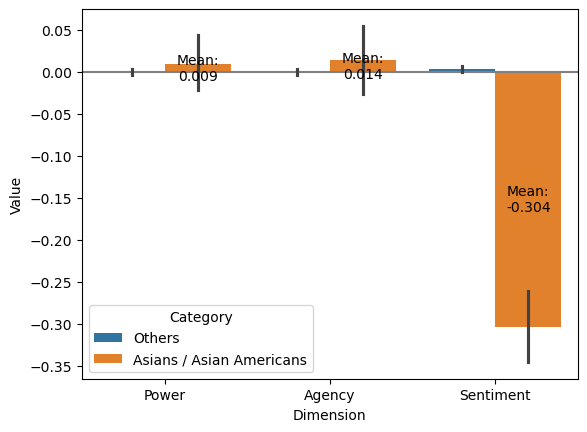

Confidence interval for sentiment: -0.2603822937787466 -0.3452637396768329


In [33]:
input_file_list = ['results/ca_people_descriptors.csv', 'results/tx_people_descriptors.csv']
lexicon_df, verb_means, verb_stds = calculate_scores(input_file_list, agencies, powers, conn_lexicon, conn_vocab)

plt.axhline(y=0, color='gray', linestyle='-')
ax = sns.barplot(x="Dimension", y="Value", hue="Category", data=lexicon_df)
ax.bar_label(ax.containers[-1], fmt='Mean:\n%.3f', label_type='center')
plt.show()
lower = [min(line.get_ydata()) for line in ax.lines]
upper = [max(line.get_ydata()) for line in ax.lines]
print("Confidence interval for sentiment:", upper[-1], lower[-1])

### Verb differences

This section and the "Verb clusters" section includes some analyses that are reported in the **Appendix** of our paper. 

Why is there such low sentiment for AA groups? We can tell from the top most frequent verbs that we get ones related to war, or calculate log-odds like in our Texas paper, but there is a "long tail" of verbs with similar meanings as well. Let's look at where are AA actions situated in the overall landscape of historical actions being done by and to people.  

To construct this landscape, we use pretrained GloVe embeddings. The location of a word embedding in space represents its meaning, e.g. "attack" and "fight" should be closer together than "attack" and "educate". I got embeddings for all verbs used by people and cluster them. This script clusters all verbs attached to people into 100 and 50 clusters: 

```
python get_word_embeddings.py
```

### Verb clusters

The results of running a Gaussian Mixture model on lemmatized patient and agent verbs with 100 clusters. We chose 100 clusters because it offered enough granularity to produce clusters where words are nearly synonyms, while clusters were still large enough to allow different word types associated with AA terms to be linked together. Representatives of each cluster are words that have the highest maximal density for that cluster that appear at least ten times. 

We cluster patient and agent verbs separately so that representatives for patient verbs' clusters are transitive verbs, which eases their conceptual interpretation. 

First, we can print out the number of clusters, followed by all of the clusters and words that have that cluster label. 

In [34]:
# Load clusters
k = 50
with open('./results/' + str(k) + '_agent_verb_clusters.json', 'r') as infile: 
    agent_clusters = json.load(infile)
with open('./results/' + str(k) + '_patient_verb_clusters.json', 'r') as infile: 
    patient_clusters = json.load(infile)
# Go from word to cluster 
patient_clusters_rev = {}
for clust in patient_clusters: 
    clust_num = clust.split(' @ ')[0]
    for word in patient_clusters[clust]: 
        patient_clusters_rev[word] = clust_num
agent_clusters_rev = {}
for clust in agent_clusters: 
    clust_num = clust.split(' @ ')[0]
    for word in agent_clusters[clust]: 
        agent_clusters_rev[word] = clust_num

In [35]:
# Print out a couple of clusters and a sample of verbs just to see what they're like 
cluster_sample = random.sample(list(agent_clusters.keys()), 20)
for clust in cluster_sample: 
    if len(agent_clusters[clust]) > 10: 
        sample = random.sample(agent_clusters[clust], 10)
    else: 
        sample = agent_clusters[clust]
    clust_reps = clust.split(' @ ')[1].upper()
    print(len(agent_clusters[clust]), clust_reps, '----', ' '.join(sample))

113 RESULT, PRESENT, COMPRISE, ---- calculate outline compound measure separate trace contrast transfer result effect
36 SCOLD, CONFIDE, CHIDE, ---- harangue scoff bellyache obsess quarrel chide babble castigate berate squabble
28 ANNEX, ASSEMBLE, CONSTRUCT, ---- plumb sculpt cobble excavate canvass embellish fabricate annex buttress cement
61 CAPTIVATE, NURTURE, INSPIRE, ---- soften arouse illuminate radiate entice cultivate inspire conjure immerse flaunt
65 FLOOD, WAKE, BLAST, ---- burst trickle wake plunge storm drift creep tumble slight explode
52 REENTER, REENTERED, ---- superimpose reconquer reoccupied retell mechanize redrew formalize redecorate resettle reexamine
81 DISAGREE, CONDEMN, SYMPATHIZE, ---- conclude contradict criticize insult justify concur denounce detest ascribe deplore
138 HELP, ENHANCE, PROVIDE, ---- engineer strengthen enhance integrate recognize endeavour operate employ apply clarify
79 VEST, WRAP, BEND, ---- sew purse tuck wear tie slat fold satin dangle trea

Then, we examine which clusters tend to be very frequent with AA terms. We also include which clusters are highly *associated* with AA terms using NPMI of verb cluster $v$ and people category $a$, where: 

$$\text{pmi}(v, a) = \log{\frac{p(v|a)}{p(v)}} $$

$$\text{npmi}(v, a) = \frac{\text{pmi}(v, a)}{-\log p(v, a)}$$

Here, $p(v|a)$ is the average probability of a cluster across verbs co-occurring with AA terms, which are the cluster probabilities generated by the GMM model. $p(v)$ is the average probability of a cluster for all verbs. To calculate the joint probability, we use the probability of a verb co-occurring with AA terms: 

$$p(v, a) = p(v|a)p(a)$$



In [36]:
def get_npmi_aa_helper(all_verbs, aa_verbs, verb_type): 
    '''
    @inputs: 
    - all_verbs: all agent verbs or all patient verbs, as list
    - aa_verbs: agent verbs or patient verbs, as a list, in a state, associated with AA
    '''
    probs = np.load(ROOT + 'results/' + str(k) + '_' + verb_type + '_probs.npy')
    verb_probs = {} # {verb : [probs]}
    with open(ROOT + 'results/' + str(k) + '_' + verb_type + '_vocab.txt', 'r') as infile: 
        line_num = 0
        for line in infile: 
            verb_probs[line.strip()] = probs[line_num]
            line_num += 1
            
    p_v_given_a = []
    p_v = []
    p_a = len(aa_verbs) / len(all_verbs)
    for v in all_verbs: 
        if v in verb_probs: 
            p_v.append(verb_probs[v])
    p_v = np.mean(p_v, axis=0)
    for v in aa_verbs: 
        if v in verb_probs: 
            p_v_given_a.append(verb_probs[v])
    p_v_given_a = np.mean(p_v_given_a, axis=0)
    p_v_a = p_v_given_a * p_a
    
    npmi_dict = Counter() # {cluster : npmi w/ AA}
    for i in range(k): 
        if p_v_given_a[i] == 0: continue
        pmi = math.log(p_v_given_a[i] / p_v[i])
        npmi_dict[i] = round(pmi / (-math.log(p_v_a[i])), 2)
    return npmi_dict
    
def get_npmi_aa(df, verb_df): 
    '''
    Example usage: get_npmi_aa(ca_descript_df), get_npmi_aa(tx_descript_df)
    @inputs: 
    - df: dataframe of verbs
    @outputs: 
    - npmi dictionaries of cluster ID to npmi w/ AA terms
    '''
    all_verbs_df = df[df['POS'] == 'VERB']
    all_agents = all_verbs_df[all_verbs_df['rel'] == 'nsubj']['word'].to_list()
    all_agents = [WordNetLemmatizer().lemmatize(v, 'v') for v in all_agents]
    all_patients = all_verbs_df[all_verbs_df['rel'].isin(['nsubjpass', 'dobj'])]['word'].to_list()
    all_patients = [WordNetLemmatizer().lemmatize(v, 'v') for v in all_patients]
    
    agents = verb_df[verb_df['rel'] == 'nsubj']['word'].to_list()
    agents = [WordNetLemmatizer().lemmatize(v, 'v') for v in agents]
    patients = verb_df[verb_df['rel'].isin(['nsubjpass', 'dobj'])]['word'].to_list()
    patients = [WordNetLemmatizer().lemmatize(v, 'v') for v in patients]
    
    agent_npmi = get_npmi_aa_helper(all_agents, agents, 'agent')
    patient_npmi = get_npmi_aa_helper(all_patients, patients, 'patient')
    return agent_npmi, patient_npmi

In [37]:
def get_cluster_sentiment_scores(verb_lemmas, verb_clust_rev, conn_lexicon, perspective): 
    '''
    @inputs: 
    - verb_lemmas: a list of non-unique AA verbs, such as patient or agent verbs
    - verb_clust_rev:  a dictionary mapping from word to cluster ID
    @outputs: 
    - scores: lexicon scores for verbs that appear and belong to a cluster 
    - clust: cluster ID to list of AA verbs
    '''
    scores = defaultdict(list)
    clust = defaultdict(list)
    for v in verb_lemmas: 
        if v not in verb_clust_rev: 
            c = 'unknown'
        else: 
            c = verb_clust_rev[v]
        clust[c].append(v)
        if v in conn_lexicon[perspective]: 
            s = conn_lexicon[perspective][v]
            # z-score 
            s = (s - verb_means['Sentiment']) / verb_stds['Sentiment']
            scores[c].append(s)
    return scores, clust
    
def show_top_npmi(npmi_dict, clust, sentiment_scores, title): 
    '''
    @inputs: 
    - npmi_dict: cluster ID to npmi w/ AA terms
    - clust: cluster ID to AA verbs
    - sentiment_scores: a dictionary mapping from cluster ID to list of sentiment scores
    '''
    print(title)
    print("cluster_ID\texamples\tnpmi\tsentiment\ttype\tcount".upper())
    for tup in npmi_dict.most_common(10): 
        clust_ID = str(tup[0])
        npmi = str(tup[1])
        num_types = str(len(set(clust[clust_ID])))
        total_count = str(len(clust[clust_ID]))
        if len(sentiment_scores[clust_ID]) > 0: 
            mean_score = str(round(np.mean(sentiment_scores[clust_ID]), 2))
            std_score = '(' + str(round(np.std(sentiment_scores[clust_ID]), 2)) + ')'
        else: 
            mean_score = 'None'
            std_score = '(None)'
        type_count = Counter(clust[clust_ID])
        examples = ', '.join([t[0] for t in type_count.most_common(3)])
        print(clust_ID + '\t' + examples + '\t' + npmi + '\t' + mean_score + ' ' + std_score + '\t' + \
              num_types + '\t' + total_count)

def get_top_clusters(df, conn_lexicon):
    all_verbs_df = df[df['POS'] == 'VERB']
    all_agents = all_verbs_df[all_verbs_df['rel'] == 'nsubj']['word'].to_list()
    all_agents = [WordNetLemmatizer().lemmatize(v, 'v') for v in all_agents]
    all_patients = all_verbs_df[all_verbs_df['rel'].isin(['nsubjpass', 'dobj'])]['word'].to_list()
    all_patients = [WordNetLemmatizer().lemmatize(v, 'v') for v in all_patients]
    
    aa_df = df[df['category'] == 'aapi']
    verb_df = aa_df[aa_df['POS'] == 'VERB']
    agents = verb_df[verb_df['rel'] == 'nsubj']['word'].to_list()
    agents = [WordNetLemmatizer().lemmatize(v, 'v') for v in agents]
    patients = verb_df[verb_df['rel'].isin(['nsubjpass', 'dobj'])]['word'].to_list()
    patients = [WordNetLemmatizer().lemmatize(v, 'v') for v in patients]
    
    agent_npmi, patient_npmi = get_npmi_aa(df, verb_df)
    
    scores, clust = get_cluster_sentiment_scores(agents, agent_clusters_rev, conn_lexicon, 'Perspective(ws)')
    show_top_npmi(agent_npmi, clust, scores, "** AGENT VERBS BY NPMI **")
    print()

    scores, clust = get_cluster_sentiment_scores(patients, patient_clusters_rev, conn_lexicon, 'Perspective(wo)')
    show_top_npmi(patient_npmi, clust, scores, "** PATIENT VERBS BY NPMI **")
    print()
    

**Cluster results table**

The column titles in these tab-delimited tables below: 
- TYPES: number of distinct word types in cluster associated with AA terms, or type counts
- COUNT: frequency of cluster for AA terms, or token counts
- NPMI: normalized pointwise mutual informatoin 
- SENTIMENT: average and standard deviation of sentiment for verbs in cluster associated with AA terms
- CLUSTER: representatives of cluster
- EXAMPLES: three most common verbs attached to AA in that cluster

Note that tab-delimited tables are not very readable in a Jupyter Notebook and the columns are more distinct when copied into Excel / Google Sheet / other table. 

In [38]:
ca_descript_df['state'] = 'CA'
tx_descript_df['state'] = 'TX'
# Background verb probabilities are calculated from entire stacked_df
stacked_df = pd.concat([ca_descript_df, tx_descript_df])

In [39]:
get_top_clusters(stacked_df, conn_lexicon)

** AGENT VERBS BY NPMI **
CLUSTER_ID	EXAMPLES	NPMI	SENTIMENT	TYPE	COUNT
9	attack, fight, surrender	0.19	-2.11 (1.51)	17	219
46	invade, flee, destroy	0.18	-1.77 (0.64)	17	101
3	drive, push, sweep	0.09	-0.83 (1.09)	16	51
41	sink, pressure, filter	0.09	-0.87 (0.0)	6	15
36	threaten, circumvent, misrepresent	0.08	-2.47 (0.31)	6	19
19	face, cross, retreat	0.06	-0.04 (0.5)	16	88
1	outnumber, overpower	0.05	None (None)	2	6
21	suffer, resist, damage	0.05	-0.54 (1.28)	9	40
25	kill, crush, lay	0.05	-2.41 (1.78)	12	35
30	mistreat, assassinate, brutalize	0.05	None (None)	4	6

** PATIENT VERBS BY NPMI **
CLUSTER_ID	EXAMPLES	NPMI	SENTIMENT	TYPE	COUNT
25	civilize, reunify	0.19	None (None)	2	8
28	christianize, resupplying	0.18	None (None)	2	15
34	evacuate, oust, firebomb	0.18	-0.42 (0.0)	8	28
41	force, fight, defeat	0.17	-1.25 (1.1)	13	156
38	segregate, alienate, misrepresent	0.12	None (None)	9	19
10	kill, prevent, warn	0.11	-0.82 (0.93)	9	96
19	bar, arm, lift	0.11	-1.15 (0.1)	4	24
23	tie, stretch, ply

In [40]:
def show_examples(df, verb_type, clust): 
    aa_df = df[df['category'] == 'aapi']
    verb_df = aa_df[aa_df['POS'] == 'VERB']
    agents = Counter(verb_df[verb_df['rel'] == 'nsubj']['word'].to_list())
    patients = Counter(verb_df[verb_df['rel'].isin(['nsubjpass', 'dobj'])]['word'].to_list())
    
    if verb_type == 'agent': 
        i = 0
        for k in agent_clusters: 
            if k.startswith(clust): 
                c = agent_clusters[k]
        for tup in agents.most_common(): 
            w = WordNetLemmatizer().lemmatize(tup[0], 'v')
            if w in c: 
                print(tup)
                i += 1
            if i == 10: break
    elif verb_type == 'patient': 
        i = 0
        for k in patient_clusters: 
            if k.startswith(clust): 
                c = patient_clusters[k]
        for tup in patients.most_common(): 
            w = WordNetLemmatizer().lemmatize(tup[0], 'v')
            if w in c: 
                print(tup)
                i += 1
            if i == 10: break

The cell below prints out specific examples of verbs that fall into a cluster that are associated with AA terms, and their frequency. 

In [41]:
show_examples(stacked_df, 'agent', '9')

('attacked', 54)
('fought', 29)
('surrendered', 19)
('fight', 14)
('fighting', 14)
('forced', 13)
('bombed', 8)
('surrender', 8)
('rebelled', 7)
('battled', 6)


# Topics associated with Asians / Asian Americans

Generate a csv with one sentence per row for texts: 

```python generate_sentence_csv.py --input_dir data/coref_resolved_ca --state_name CA --output_prefix logs/ca_coref```

```python generate_sentence_csv.py --input_dir data/coref_resolved_tx --state_name TX --output_prefix logs/tx_coref```

Combine California and Texas sentences that are the output of `generate_sentence_csv.py`: 

```cat ca_coref_data.csv tx_coref_data.csv > combined_coref_data.csv```

The ordering of documents in the output of topic modeling should follow the ordering in this file. 

Run topic modeling for 50 topics: 

```python get_topics.py --mallet_dir path/to/your/mallet-2.0.8/bin --num_topics 50 --input_file logs/combined_coref_data.csv --output_dir topics/topics_50 --people_terms wordlists/people_terms.csv```

Sentences after preprocessing needed to have at least five words to be included as a document. We don't stem words since it has been shown in previous work to degrade topics. 

We also round dates to each decade, e.g. '1234' -> '1230' so that they occur often enough to be counted as a token.

Get topic probabilties for AA and non-AA sentences: 

```python get_topic_probabilities.py --sentence_file ./logs/combined_coref_data.csv --topic_dir ./topics/topics_50/ --people_terms wordlists/people_terms.csv --output_file ./logs/combined_coref_data_topics_50.csv```

A sentence is labeled as "aa" if there is a person or people marked with an AA term in it. (Note that in some places in this notebook, we say "aapi", e.g. in column titles. We actually do not include terms related to Pacific Islanders in the final our analysis included in our paper, and this is an artifact of earlier iterations of our code.)

In [42]:
def load_topics(topic_path): 
    with open(topic_path + 'topic_names.json', 'r') as infile: 
        topics = json.load(infile)
    return topics

In [43]:
num_topics = 50
topics_50 = load_topics('./topics/topics_50/')

In [44]:
dtypes = {'state':str, 'book_id':str, 'book_filename':str, 'subject':str, 
          'sentence_id':str, 'sentence':str, 'aapi':str}
for i in range(num_topics): 
    dtypes['topic_' + str(i)] = float
sent_topics_50 = pd.read_csv(LOGS + 'combined_coref_data_topics_50.csv', dtype=dtypes)
aa_sent_topics_50 = sent_topics_50[sent_topics_50.aapi.notnull()]
aa_sent_topics_50.head()

,state,book_id,book_filename,subject,sentence_id,sentence,aapi,topic_0,topic_1,topic_2,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
288,CA,0,"America Through the Lens, U.S. History 1877 to...",history,288,"b'SUMMARIZE According to some scientists, how ...",asians,0.01250,0.01250,0.01250,...,0.01250,0.13750,0.01250,0.01250,0.01250,0.01250,0.01250,0.01250,0.01250,0.01250
2255,CA,0,"America Through the Lens, U.S. History 1877 to...",history,2255,"b'United through heritage, culture, language, ...",chinese,0.00556,0.00556,0.00556,...,0.00556,0.00556,0.00556,0.00556,0.00556,0.00556,0.00556,0.00556,0.00556,0.00556
2368,CA,0,"America Through the Lens, U.S. History 1877 to...",history,2368,b'C mostly Chinese immigrants and free African...,chinese,0.01250,0.01250,0.01250,...,0.01250,0.01250,0.01250,0.01250,0.01250,0.01250,0.13750,0.13750,0.01250,0.01250
3346,CA,0,"America Through the Lens, U.S. History 1877 to...",history,3346,b'The Chinese Exclusion Act severely limits th...,chinese,0.01000,0.01000,0.01000,...,0.01000,0.01000,0.01000,0.01000,0.01000,0.01000,0.01000,0.01000,0.01000,0.01000
3995,CA,0,"America Through the Lens, U.S. History 1877 to...",history,3995,b'Like most Americans of the late 19th century...,asians,0.00500,0.00500,0.00500,...,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500,0.00500


**Average topic probabilities in sentences containing AA**

This shows the average probability of a topic in sentences containing AA words, sorted from highest to lowest probability. 

In [45]:
topic_columns = ['topic_' + str(i) for i in range(num_topics)]
topic_means = aa_sent_topics_50[topic_columns].mean(skipna=True).to_dict()
sorted_topic_means = sorted(topic_means.items(), key=lambda kv: kv[1])[::-1]
print("ID\tPROB\tWORDS IN TOPIC")
for tup in sorted_topic_means: 
    topic_num = tup[0].split('_')[-1]
    word_list = topics_50[topic_num].replace(',', ', ')
    print(str(topic_num) + '\t' + str(round(tup[1], 5)) + '\t' + word_list)

ID	PROB	WORDS IN TOPIC
36	0.05607	war, vietnam, world, civil, military, united states, north, south, troops, end
12	0.05345	ships, navy, british, ship, pacific, sea, japan, attack, naval, island
11	0.03886	general, army, troops, forces, confederate, union, grant, soldiers, battle, lee
3	0.03557	killed, soldiers, died, thousands, death, destroyed, prisoners, hundreds, killing, disease
41	0.03513	soviet union, communist, soviet, eisenhower, china, cold war, truman, communism, military, soviets
38	0.03478	african, americans, white, black, native, blacks, whites, south, american, people
8	0.0282	germany, german, france, allies, hitler, tl1e, germans, europe, japan, jews
9	0.02705	act, laws, law, passed, immigration, federal, civil rights, congress passed, immigrants, established
14	0.02572	united states, world, nations, european, countries, europe, international, trade, foreign, power
1	0.02524	mexico, mexican, texas, spanish, united states, california, spain, florida, cuba, independence
4

This code snippet can show **examples of sentences** that are assigned to a specific topic. 

In [4]:
aa_sent_topics_50.loc[:,'max_topic'] = aa_sent_topics_50[topic_columns].idxmax(axis=1)
example_sents = aa_sent_topics_50[aa_sent_topics_50['max_topic'] == 'topic_15'][['sentence', 'book_filename']]
print(example_sents.iloc[26,0])
print(example_sents.iloc[26,1])

The code snippet below shows how one can get examples of sentences in a topic that contain a specific word, such as "wanted" and "German". 

In [5]:
sent_topics_50.loc[:,'max_topic'] = sent_topics_50[topic_columns].idxmax(axis=1)
example_sents = sent_topics_50[sent_topics_50['max_topic'] == 'topic_8'][['sentence', 'book_filename']]
subset = example_sents[example_sents['sentence'].str.contains('German')]
subset[subset['sentence'].str.contains('wanted')]['sentence'].to_list()

**Topic breakdown based on social group**

Here, we show the topics based on their popularity for different nationalities. I included the nationalities that show up the most since they're more likely to have aggregateable trends. 

In [48]:
print(Counter(aa_sent_topics_50['aapi'].to_list()).most_common(20))

[('japanese', 1678), ('chinese', 1163), ('vietnamese', 772), ('asian', 316), ('filipinos', 232), ('filipino', 181), ('asians', 147), ('korean', 141), ('koreans', 82), ('japanese, chinese', 54), ('chinese, korean', 14), ('asian, asians', 13), ('cambodians', 12), ('chinese, koreans', 9), ('japanese, filipino', 8), ('japanese, asians', 7), ('japanese, filipinos', 6), ('cambodian', 6), ('asians, chinese', 6), ('japanese, asian', 5)]


In [49]:
popular_groups = ['japanese', 'chinese', 'vietnamese', 'korean', 'asian', 'filipino', 'cambodian']
for group in popular_groups: 
    group_df = aa_sent_topics_50[aa_sent_topics_50['aapi'].str.contains(group)]
    group_means = group_df[topic_columns].mean(skipna=True).to_dict()
    top_topics = Counter(group_means).most_common(5)
    print(group.upper())
    for tup in top_topics: 
        topic_num = tup[0].split('_')[-1]
        word_list = topics_50[topic_num].replace(',', ', ')
        print(str(topic_num) + '\t' + str(round(tup[1], 5)) + '\t' + word_list)
    print()

JAPANESE
12	0.10549	ships, navy, british, ship, pacific, sea, japan, attack, naval, island
8	0.04441	germany, german, france, allies, hitler, tl1e, germans, europe, japan, jews
3	0.03701	killed, soldiers, died, thousands, death, destroyed, prisoners, hundreds, killing, disease
36	0.03433	war, vietnam, world, civil, military, united states, north, south, troops, end
11	0.03275	general, army, troops, forces, confederate, union, grant, soldiers, battle, lee

CHINESE
41	0.05021	soviet union, communist, soviet, eisenhower, china, cold war, truman, communism, military, soviets
26	0.04289	workers, labor, work, jobs, strike, unions, union, industrial, employers, wages
9	0.04234	act, laws, law, passed, immigration, federal, civil rights, congress passed, immigrants, established
46	0.03841	cities, city, immigrants, urban, york, york city, chicago, residents, lived, rural
20	0.03588	west, native, land, settlers, tribes, western, lands, plains, frontier, california

VIETNAMESE
36	0.1809	war, vietn

Below, we manually annotate which topic numbers correspond to the following two groups: war and immigration/civil rights. Then, we plot the average probability of these topic groups across books in each state. 

We combine multi-volume books together. 

In [50]:
# nested dictionary of {topic_num : { book_filename : mean probability }}
def calculate_topic_group_prominence(topic_group, topic_group_name): 
    print("TOPICS IN " + topic_group_name.upper() + " GROUP:")
    for topic_num in topic_group: 
        word_list = topics_50[str(topic_num)].replace(',', ', ')
        print(topic_num, word_list)
    this_topic = []
    not_this_topic = []
    for i in range(num_topics): 
        if i in topic_group: 
            this_topic.append('topic_' + str(i))
        else: 
            not_this_topic.append('topic_' + str(i))
    aa_sent_topics_50.loc[:,'this_topic_total'] = aa_sent_topics_50.loc[:,this_topic].sum(axis=1)
    aa_sent_topics_50.loc[:,'not_this_topic_total'] = aa_sent_topics_50.loc[:,not_this_topic].sum(axis=1)
    book_topic_df = aa_sent_topics_50[['book_filename', 'this_topic_total', 'not_this_topic_total']]
    book_topic_df = book_topic_df.replace(combine_volume_dict)
    book_topic_df = book_topic_df.groupby('book_filename')[['this_topic_total', 'not_this_topic_total']].mean()
    book_topic_prob = book_topic_df['this_topic_total'].to_dict()
    return book_topic_prob

In [51]:
war_topics = set([36, 12, 11, 3, 41, 8, 1])
book_war_prob = calculate_topic_group_prominence(war_topics, 'war')

TOPICS IN WAR GROUP:
1 mexico, mexican, texas, spanish, united states, california, spain, florida, cuba, independence
3 killed, soldiers, died, thousands, death, destroyed, prisoners, hundreds, killing, disease
36 war, vietnam, world, civil, military, united states, north, south, troops, end
8 germany, german, france, allies, hitler, tl1e, germans, europe, japan, jews
41 soviet union, communist, soviet, eisenhower, china, cold war, truman, communism, military, soviets
11 general, army, troops, forces, confederate, union, grant, soldiers, battle, lee
12 ships, navy, british, ship, pacific, sea, japan, attack, naval, island


/tmp/ipykernel_30626/723294465.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapi_sent_topics_50.loc[:,'this_topic_total'] = aapi_sent_topics_50.loc[:,this_topic].sum(axis=1)
/tmp/ipykernel_30626/723294465.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapi_sent_topics_50.loc[:,'not_this_topic_total'] = aapi_sent_topics_50.loc[:,not_this_topic].sum(axis=1)


In [52]:
immigr_civil_topics = set([38, 9, 46, 39, 0, 31, 15, 17, 19])
book_immigr_civil_prob = calculate_topic_group_prominence(immigr_civil_topics, 'IMMIGRANTS / RIGHTS')

TOPICS IN IMMIGRANTS / RIGHTS GROUP:
0 king, students, civil rights, black, march, protest, african, washington, police, martin luther
38 african, americans, white, black, native, blacks, whites, south, american, people
39 percent, million, number, population, half, years, year, twenty, increased, total
9 act, laws, law, passed, immigration, federal, civil rights, congress passed, immigrants, established
46 cities, city, immigrants, urban, york, york city, chicago, residents, lived, rural
15 supreme court, court, law, case, decision, legal, courts, cases, ruled, person
17 freedom, liberty, rights, free, democracy, individual, citizens, idea, equality, human
19 bill, vote, constitution, states, congress, state, amendment, senate, house, rights
31 movement, women, rights, civil rights, reform, social, groups, national, reformers, political


Examine the `max_topic`s of Asian/Asian American sentences, and print out the percentage of sentences within each topic grouping if each sentence were assigned to its most probable topic. 

In [53]:
aa_max_topics = Counter(aa_sent_topics_50['max_topic'].to_list())
war_topic_total = 0
for topic in war_topics: 
    war_topic_total += aa_max_topics['topic_' + str(topic)]
print(war_topic_total, war_topic_total / sum(aa_max_topics.values()))
immigr_civil_total = 0
for topic in immigr_civil_topics: 
    immigr_civil_total += aa_max_topics['topic_' + str(topic)]
print(immigr_civil_total, immigr_civil_total / sum(aa_max_topics.values()))
for tup in aa_max_topics.most_common(): 
    topic = int(tup[0].split('_')[-1])
    if topic not in war_topics and topic not in immigr_civil_topics: 
        # what popular topics linked to AA terms aren't in war or immigration/civil rights groups? 
        print(topic, aa_max_topics[tup[0]], topics_50[str(topic)].replace(',', ', '))

2227 0.4517241379310345
942 0.19107505070993916
26 136 workers, labor, work, jobs, strike, unions, union, industrial, employers, wages
14 134 united states, world, nations, european, countries, europe, international, trade, foreign, power
20 115 west, native, land, settlers, tribes, western, lands, plains, frontier, california
10 102 people, man, country, good, great, make, wrote, things, god, live
6 87 president, johnson, nixon, kennedy, reagan, bush, administration, clinton, carter, richard nixon
23 82 day, water, fire, night, long, man, hand, back, house, feet
22 80 growing, debate, strong, interest, public, led, sense, politics, political, widespread
29 79 women, men, children, young, work, family, families, home, working, parents
5 78 technology, railroad, system, built, cars, factories, travel, car, railroads, steel
42 75 north, america, european, africa, europe, europeans, americas, spanish, trade, colonies
35 57 role, century, explain, world, chapter, events, history, impact, d

Some of the filenames don't match the `textbook-level_data.csv` names, so I need to manually link them. 

In [54]:
history_map = {
    'early': 'Early U.S. History',
    'later': 'Later U.S. History',
    'complete': 'Complete U.S. History'
}

textbook_to_part = {
    'America_s History combined_ca': 'complete',
    'American Anthem Modern American History, California Edition (HRW Modern American History) RINEHART AND WINSTON HOLT_CL_hyp': 'later',
    'United States History Independence to 1914_CL_hyp': 'early',
    'The Americans Reconstruction to the 21st Century_ca': 'later',
    'The Unfinished Nation Vol 1_ca': 'early',
    'United States History and Geography, Student Edition (UNITED STATES HISTORY (HS)) McGraw Hill_CL_hyp': 'complete',
    'American Odyssey_ca': 'later',
    'American Vision_ca': 'later',
    'American Journey_ca': 'complete',
    'America Through the Lens, U.S. History 1877 to the Present, California Edition_ca_2022': 'later',
    'The American People combined_ca': 'complete',
    'California, United States History, The Twentieth Century_ca_2022': 'later',
    'America, Pathways to the Present, Modern American History_ca_2022': 'later',
    'Prentice Hall, United States History, Modern America_ca_2022': 'later',
    'Give Me Liberty!, An American History_ca': 'complete',
    'The_American_Pageant_Cengage_14th (1)': 'complete',
    'America_Past_And_Present_Pearson_10th (1)': 'complete',
    'America_A_Narrative_History_WWNorton_10th (1)': 'complete',
    'Give_Me_Liberty_An_American_History_WWNorton_3rd (1)': 'complete',
    'american_history_connecting_with_the_past (1)': 'complete',
    'Americas_History_Bedford_8th (1)': 'complete',
    'by_the_people (1)': 'complete',
    'history_alive_united_states_thru_industrialism (1)': 'early',
    'hmh_the_americans_us_history_since_1877 (1)': 'later',
    'mastering_the_teks (1)': 'complete',
    'pearson_us_history (1)': 'complete',
    'teks_us_history (1)': 'complete',
    'The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th (1)': 'complete',
    'us_history_early_colonial_period_through_reconstruction (1)': 'early',
    'Visions_of_America_A_History_of_the_United_States_Pearson_2nd (1)': 'complete',
}

In [55]:
# Create a dataframe: title, state, state specific, war probability
textbook_data = pd.read_csv('./data/textbook-level_data.csv')
textbook_data = textbook_data[['File Name (.txt)', 'State', 'State-specific edition or not']].fillna(0)
di = {1.0: "Yes", 0.0: "No"}
textbook_data = textbook_data.replace({"State-specific edition or not": di})
print("These are mismatches:")
textbook_data_titles = set(textbook_data['File Name (.txt)'].to_list())
print(textbook_data_titles - set(book_war_prob.keys()))
print(set(book_war_prob.keys()) - textbook_data_titles)
replace_dict = {'The Unfinished Nation Vol 1 _ca': 'The Unfinished Nation Vol 1_ca', 
                'American_Journey_ca':'American Journey_ca',
                'America_s History': 'America_s History combined_ca', 
                'The American People_ca': 'The American People combined_ca', 
                'America_s History Concise Edition_ca': 'America_s History combined_ca', 
                'The American People Concise Edition Vol2_ca': 'The American People combined_ca',
                'The American People Concise Edition Vol 2_ca': 'The American People combined_ca',
                'America Through the Lens_ca': 'America Through the Lens, U.S. History 1877 to the Present, California Edition_ca_2022', 
                'Give Me Liberty!, An American History, Volume 1_ca': 'Give Me Liberty!, An American History_ca', 
                'Give Me Liberty!, An American History, Volume 2_ca': 'Give Me Liberty!, An American History_ca'}
for title in book_war_prob.keys(): 
    other_title = title
    if title.endswith('(1)'): 
        other_title = title + 'tx'
    if title.endswith('_2022') and title not in textbook_data_titles: 
        other_title = title.replace('_2022', '')
    replace_dict[other_title] = title
textbook_data = textbook_data.replace(replace_dict) 
print()
print("These should be empty after fixing:")
print(set(textbook_data['File Name (.txt)'].to_list()) - set(book_war_prob.keys()))
print(set(textbook_data['File Name (.txt)'].to_list()) - set(book_immigr_civil_prob.keys()))
print(set(book_war_prob.keys()) - set(textbook_data['File Name (.txt)'].to_list()))
print(set(book_immigr_civil_prob.keys()) - set(textbook_data['File Name (.txt)'].to_list()))
textbook_data['war probability'] = textbook_data['File Name (.txt)'].apply(lambda x: book_war_prob.get(x))
textbook_data['immigration / civil rights probability'] = textbook_data['File Name (.txt)'].apply(lambda x: book_immigr_civil_prob.get(x))
textbook_data['Coverage'] = textbook_data['File Name (.txt)'].apply(lambda x: history_map[textbook_to_part[x]])
textbook_data = textbook_data.drop_duplicates()
textbook_data

These are mismatches:
{'Give_Me_Liberty_An_American_History_WWNorton_3rd (1)tx', 'Americas_History_Bedford_8th (1)tx', 'Prentice Hall, United States History, Modern America_ca', 'America Through the Lens_ca', 'history_alive_united_states_thru_industrialism (1)tx', 'hmh_the_americans_us_history_since_1877 (1)tx', 'America_s History', 'California, United States History, The Twentieth Century_ca', 'The American People Concise Edition Vol2_ca', 'us_history_early_colonial_period_through_reconstruction (1)tx', 'The Unfinished Nation Vol 1 _ca', 'Give Me Liberty!, An American History, Volume 1_ca', 'mastering_the_teks (1)tx', 'America_A_Narrative_History_WWNorton_10th (1)tx', 'American_Journey_ca', 'The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th (1)tx', 'american_history_connecting_with_the_past (1)tx', 'The American People_ca', 'The_American_Pageant_Cengage_14th (1)tx', 'America_s History Concise Edition_ca', 'teks_us_history (1)tx', 'by_the_people (1)tx', 'pe

,File Name (.txt),State,State-specific edition or not,war probability,immigration / civil rights probability,Coverage
0,America_s History combined_ca,CA,No,0.263294,0.210801,Complete U.S. History
2,"American Anthem Modern American History, Calif...",CA,Yes,0.288067,0.166126,Later U.S. History
3,United States History Independence to 1914_CL_hyp,CA,Yes,0.191601,0.191005,Early U.S. History
4,The Americans Reconstruction to the 21st Centu...,CA,Yes,0.286717,0.188162,Later U.S. History
5,The Unfinished Nation Vol 1_ca,CA,No,0.114646,0.162596,Early U.S. History
6,"United States History and Geography, Student E...",CA,No,0.328634,0.154532,Complete U.S. History
7,American Odyssey_ca,CA,No,0.374824,0.107647,Later U.S. History
8,American Vision_ca,CA,Yes,0.373473,0.139320,Later U.S. History
9,American Journey_ca,CA,No,0.372599,0.143116,Complete U.S. History
10,"America Through the Lens, U.S. History 1877 to...",CA,Yes,0.262702,0.221766,Later U.S. History


The below code generates **Figure 3** of our paper.

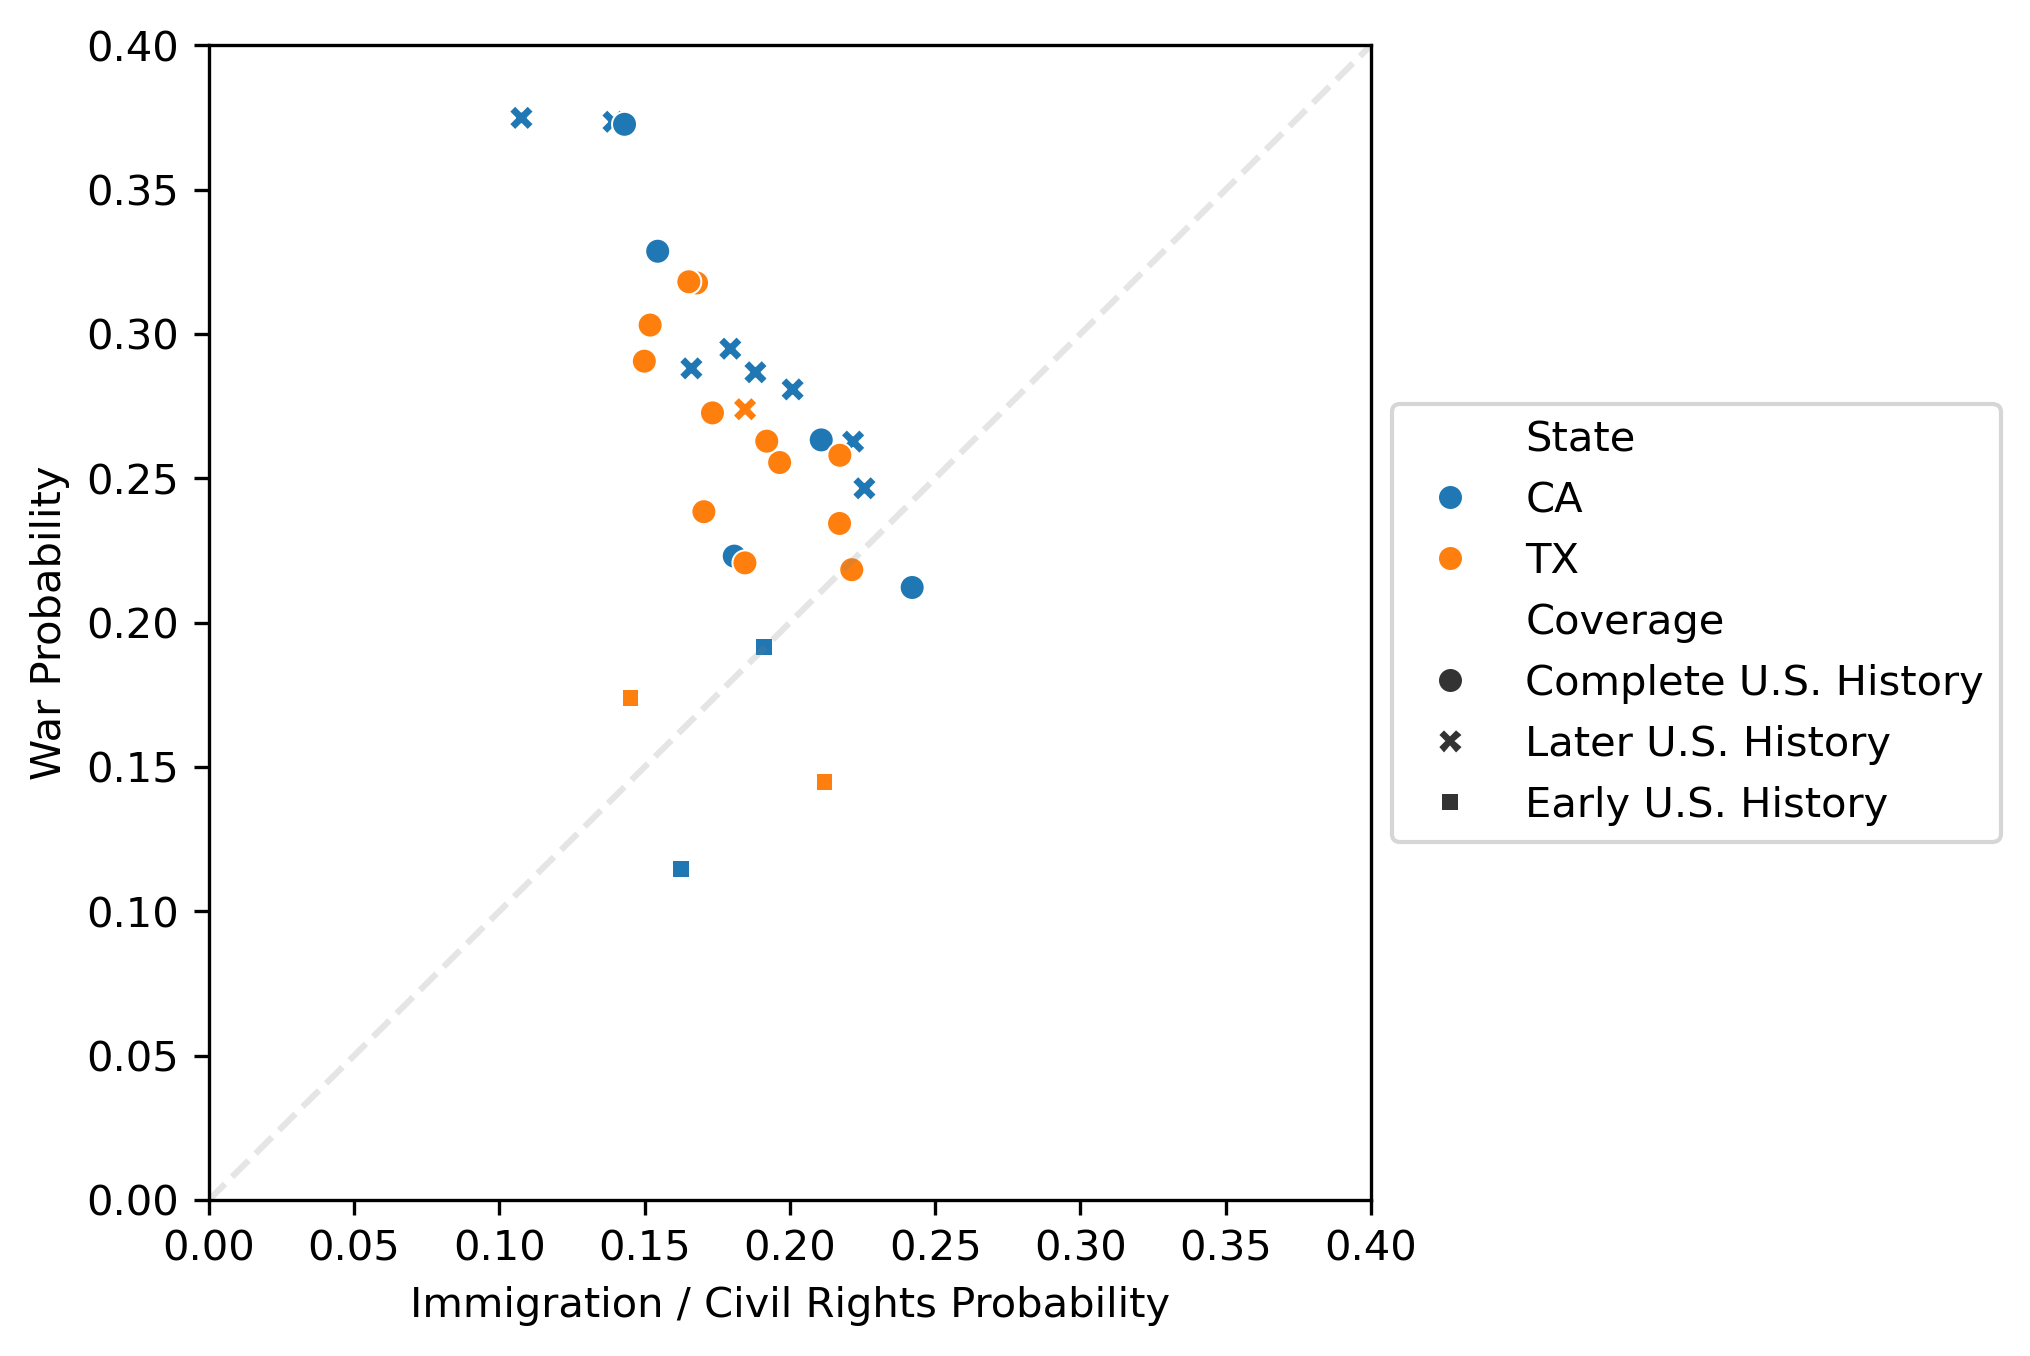

In [56]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300, sharey=True)

plt.plot([0, 0.4], [0, 0.4], linestyle='dashed', color='gray', alpha = 0.2)
sns.scatterplot(data=textbook_data, x="immigration / civil rights probability", y="war probability", 
                style="Coverage", hue='State')
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)
plt.xlabel("Immigration / Civil Rights Probability")
plt.ylabel("War Probability")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Probability of war between Asians/Asian Americans vs. overall**

Single sample $t$-test.

In [57]:
from scipy.stats import ttest_1samp

0.14328734284154415 0.272517046653144
TtestResult(statistic=46.606858201756786, pvalue=0.0, df=4929)


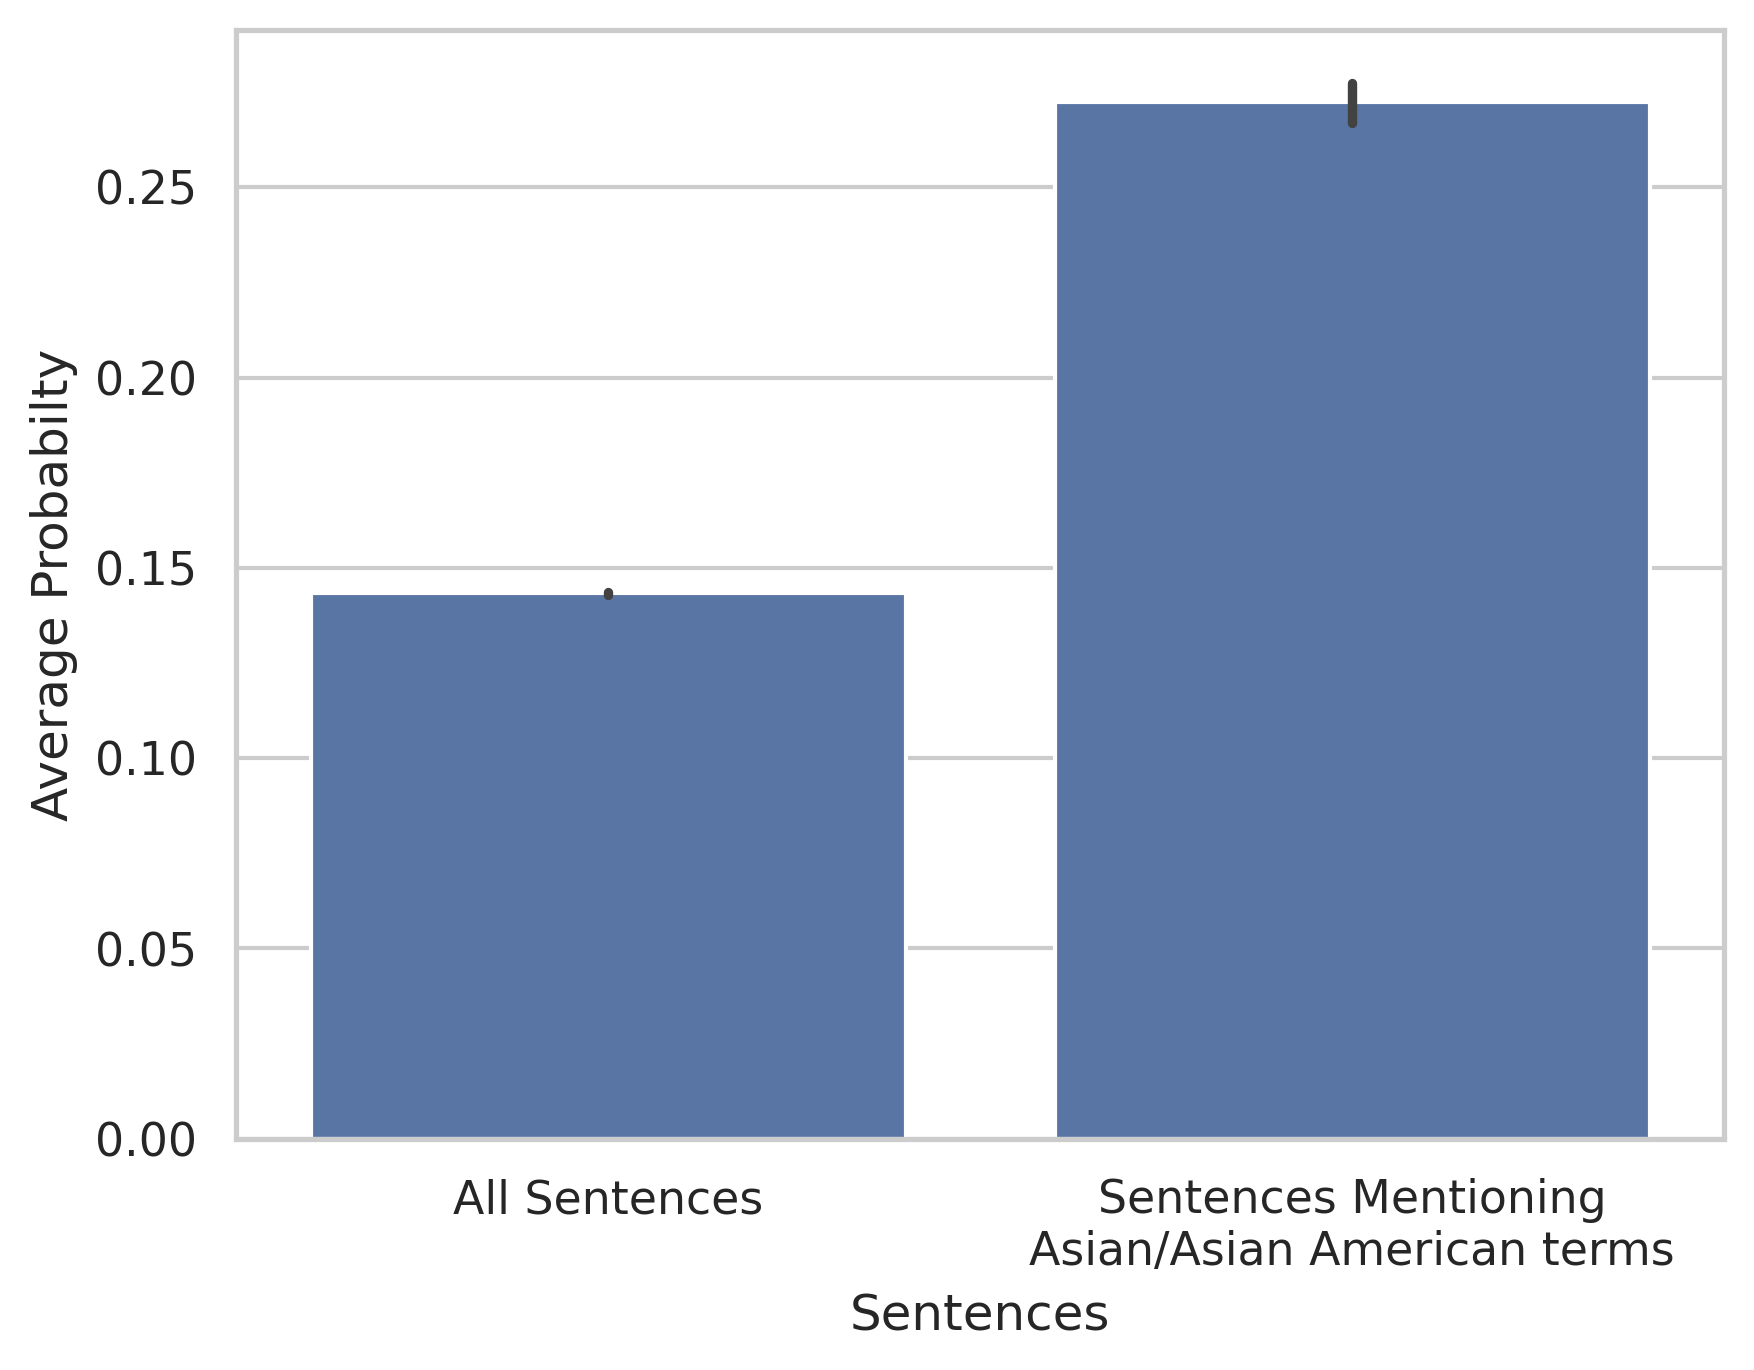

In [58]:
# calculate average prob of war topics
expected_war_prev = sent_topics_50[['topic_' + str(i) for i in war_topics]].dropna().sum(axis=1).mean()
aa_war_prev = aa_sent_topics_50[['topic_' + str(i) for i in war_topics]].dropna().sum(axis=1).mean()
print(expected_war_prev, aa_war_prev)
war_dist_d = {
    'Sentences': [], 
    'Average Probability of War Topics': []
}
all_war_dist = sent_topics_50[['topic_' + str(i) for i in war_topics]].dropna().sum(axis=1).to_list()
aa_war_dist = aa_sent_topics_50[['topic_' + str(i) for i in war_topics]].dropna().sum(axis=1).to_list()
print(ttest_1samp(aa_war_dist, popmean=expected_war_prev, alternative='greater'))
for v in all_war_dist: 
    war_dist_d['Sentences'].append('All Sentences')
    war_dist_d['Average Probability of War Topics'].append(v)
for v in aa_war_dist: 
    war_dist_d['Sentences'].append('Sentences Mentioning\nAsian/Asian American terms')
    war_dist_d['Average Probability of War Topics'].append(v)
sns.color_palette("Paired")
sns.set(rc={"figure.dpi":300})
sns.set_style("whitegrid")
sns.barplot(data=war_dist_d, x='Sentences', y='Average Probability of War Topics')
plt.ylabel("Average Probabilty")
plt.show()

**Verb differences in topics**

Initially, it may seem "obvious" that sentiment is low for verbs associated with Asians/Asian Americans because they're mostly talked about in the context of war. In the context of not war, what's the sentiment around them there? 

First, we create two docs with one sentence per line: 
- one for war topics
- one for non-war topics

In [60]:
war_topics_str = ['topic_' + str(i) for i in war_topics]
sent_topics_50.loc[:,'max_topic'] = sent_topics_50[topic_columns].idxmax(axis=1)
non_war_sent = sent_topics_50[~sent_topics_50['max_topic'].isin(war_topics_str)]
war_sent = sent_topics_50[sent_topics_50['max_topic'].isin(war_topics_str)]
non_war_sents = non_war_sent.sentence.to_list()
war_sents = war_sent.sentence.to_list()
print("Number of non-war sentences:", len(non_war_sents))
print("Number of war sentences:", len(war_sents))

if not os.path.exists('./data/subset/non_war_sents/'):
    os.makedirs('./data/subset/non_war_sents/')
if not os.path.exists('./data/subset/war_sents/'):
    os.makedirs('./data/subset/war_sents/')
with open('./data/subset/non_war_sents/input.txt', 'w') as outfile: 
    for sent in non_war_sents: 
        if type(sent) == float: continue # these are nans
        outfile.write(sent + '\n')
with open('./data/subset/war_sents/input.txt', 'w') as outfile: 
    for sent in war_sents: 
        if type(sent) == float: continue # these are nans
        outfile.write(sent + '\n')

Number of non-war sentences: 785716
Number of war sentences: 88410


Now run the following to get verbs _only_ on this subset of sentences: 

```python get_descriptors.py --input_dir data/subset/non_war_sents --output_prefix results/non_war --people_terms wordlists/people_terms.csv```

```python get_descriptors.py --input_dir data/subset/war_sents --output_prefix results/war --people_terms wordlists/people_terms.csv```

We can examine the types of verbs in war and non-war contexts, and verbs attached to AA terms and those attached to other people. Note that there are three types of verb relations: `nsubjpass` (*X were attacked...*), `nsubj` (*X attacked...*), and `dobj` (*... attacked X*). 

In [61]:
non_war_descript_df = pd.read_csv(ROOT + 'results/non_war_people_descriptors.csv')
temp = non_war_descript_df[non_war_descript_df['category'] == 'aapi'][['word', 'rel']]
print("Number examples, non-war aa:", len(temp))
temp1 = Counter(temp[temp['rel'] == 'nsubjpass']['word'].to_list()).most_common(20)
print(temp1)
temp1 = Counter(temp[temp['rel'] == 'nsubj']['word'].to_list()).most_common(20)
print(temp1)
temp1 = Counter(temp[temp['rel'] == 'dobj']['word'].to_list()).most_common(20)
print(temp1)
print()
temp = non_war_descript_df[non_war_descript_df['category'] != 'aapi'][['word', 'rel']]
print("Number examples, non-war others:", len(temp))
temp1 = Counter(temp[temp['rel'] == 'nsubjpass']['word'].to_list()).most_common(20)
print(temp1)
temp1 = Counter(temp[temp['rel'] == 'nsubj']['word'].to_list()).most_common(20)
print(temp1)
temp1 = Counter(temp[temp['rel'] == 'dobj']['word'].to_list()).most_common(20)
print(temp1)
print()

war_descript_df = pd.read_csv(ROOT + 'results/war_people_descriptors.csv')
temp = war_descript_df[war_descript_df['category'] == 'aapi'][['word', 'rel']]
print("Number examples, war aa:", len(temp))
temp1 = Counter(temp[temp['rel'] == 'nsubjpass']['word'].to_list()).most_common(20)
print(temp1)
temp1 = Counter(temp[temp['rel'] == 'nsubj']['word'].to_list()).most_common(20)
print(temp1)
temp1 = Counter(temp[temp['rel'] == 'dobj']['word'].to_list()).most_common(20)
print(temp1)
print()
temp = war_descript_df[war_descript_df['category'] != 'aapi'][['word', 'rel']]
print("Number examples, war others:", len(temp))
temp1 = Counter(temp[temp['rel'] == 'nsubjpass']['word'].to_list()).most_common(20)
print(temp1)
temp1 = Counter(temp[temp['rel'] == 'nsubj']['word'].to_list()).most_common(20)
print(temp1)
temp1 = Counter(temp[temp['rel'] == 'dobj']['word'].to_list()).most_common(20)
print(temp1)

Number examples, non-war aa: 1844
[('allowed', 23), ('forced', 11), ('killed', 8), ('interned', 6), ('driven', 5), ('taken', 4), ('treated', 4), ('barred', 3), ('segregated', 3), ('held', 3), ('born', 3), ('sent', 3), ('known', 3), ('recruited', 3), ('deprived', 2), ('classified', 2), ('affected', 2), ('imprisoned', 2), ('taught', 2), ('told', 2)]
[('had', 37), ('lived', 18), ('faced', 18), ('made', 18), ('began', 17), ('worked', 14), ('moved', 13), ('came', 13), ('have', 12), ('continued', 12), ('took', 11), ('formed', 11), ('arrived', 11), ('found', 11), ('went', 10), ('believed', 10), ('settled', 10), ('left', 9), ('attacked', 9), ('lost', 9)]
[('excluded', 20), ('educate', 13), ('christianize', 13), ('barred', 12), ('forced', 10), ('prohibited', 9), ('exclude', 8), ('prevented', 7), ('brought', 7), ('blocked', 6), ('banned', 6), ('attacking', 6), ('govern', 6), ('encouraged', 5), ('viewed', 5), ('married', 5), ('hired', 5), ('drove', 5), ('protect', 5), ('want', 5)]

Number example

When we say "others" above, who are we referring to? 

In [62]:
print("Most common non-Asian entities in war topics")
print(Counter(war_descript_df['entity'].to_list()).most_common(20))

Most common non-Asian entities in war topics
[('he', 1026), ('you', 1012), ('americans', 939), ('they', 770), ('the british', 724), ('the allies', 657), ('the soviet union', 610), ('the soviets', 567), ('congress', 547), ('troops', 539), ('the americans', 482), ('the germans', 473), ('soldiers', 417), ('people', 390), ('american troops', 373), ('the president', 343), ('the army', 308), ('the japanese', 282), ('others', 268), ('his', 267)]


In [63]:
non_war_lexicon_df, _, _ = calculate_scores(['results/non_war_people_descriptors.csv'], agencies, powers, \
                                                    conn_lexicon, conn_vocab, input_stats=[verb_means, verb_stds])
war_lexicon_df, _, _ = calculate_scores(['results/war_people_descriptors.csv'], agencies, powers, \
                                                    conn_lexicon, conn_vocab, input_stats=[verb_means, verb_stds])

In [64]:
non_war_lexicon_df['Topic'] = 'Other'
war_lexicon_df['Topic'] = 'War'
topic_split_df = pd.concat([non_war_lexicon_df, war_lexicon_df])
topic_split_df = topic_split_df[topic_split_df['Dimension'] == 'Sentiment']

The below plot is how we generate **Figure 4** in our paper. 

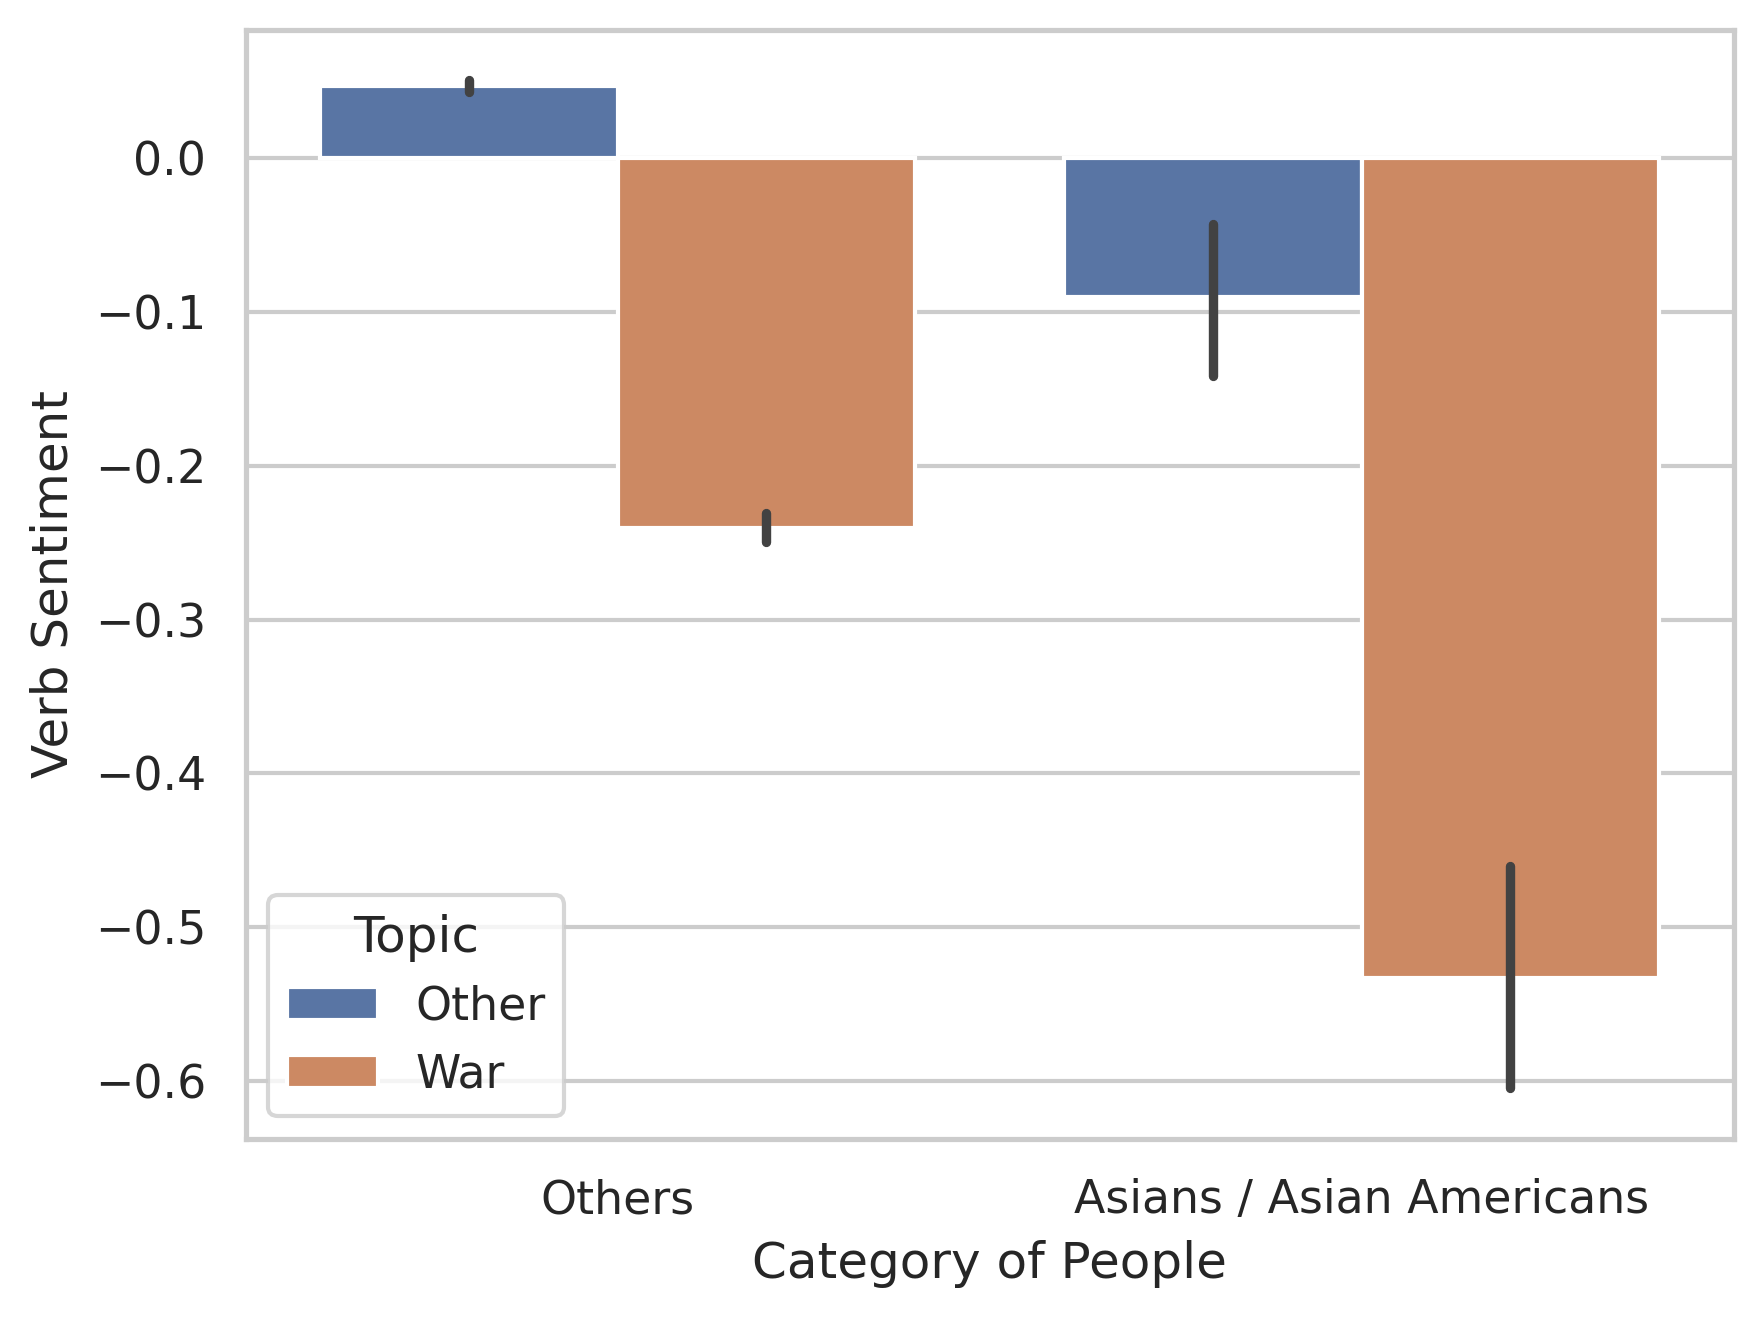

In [65]:
ax = sns.barplot(x='Category', y='Value', hue='Topic', data=topic_split_df)
plt.ylabel("Verb Sentiment")
plt.xlabel("Category of People")
plt.show()

Below, we see how Germans compare to other groups and AA terms in war-related topics. We put Germans under the "Separate" category in the plot below. 

Confidence intervals: -0.3557836437596514 -0.22767974593021445


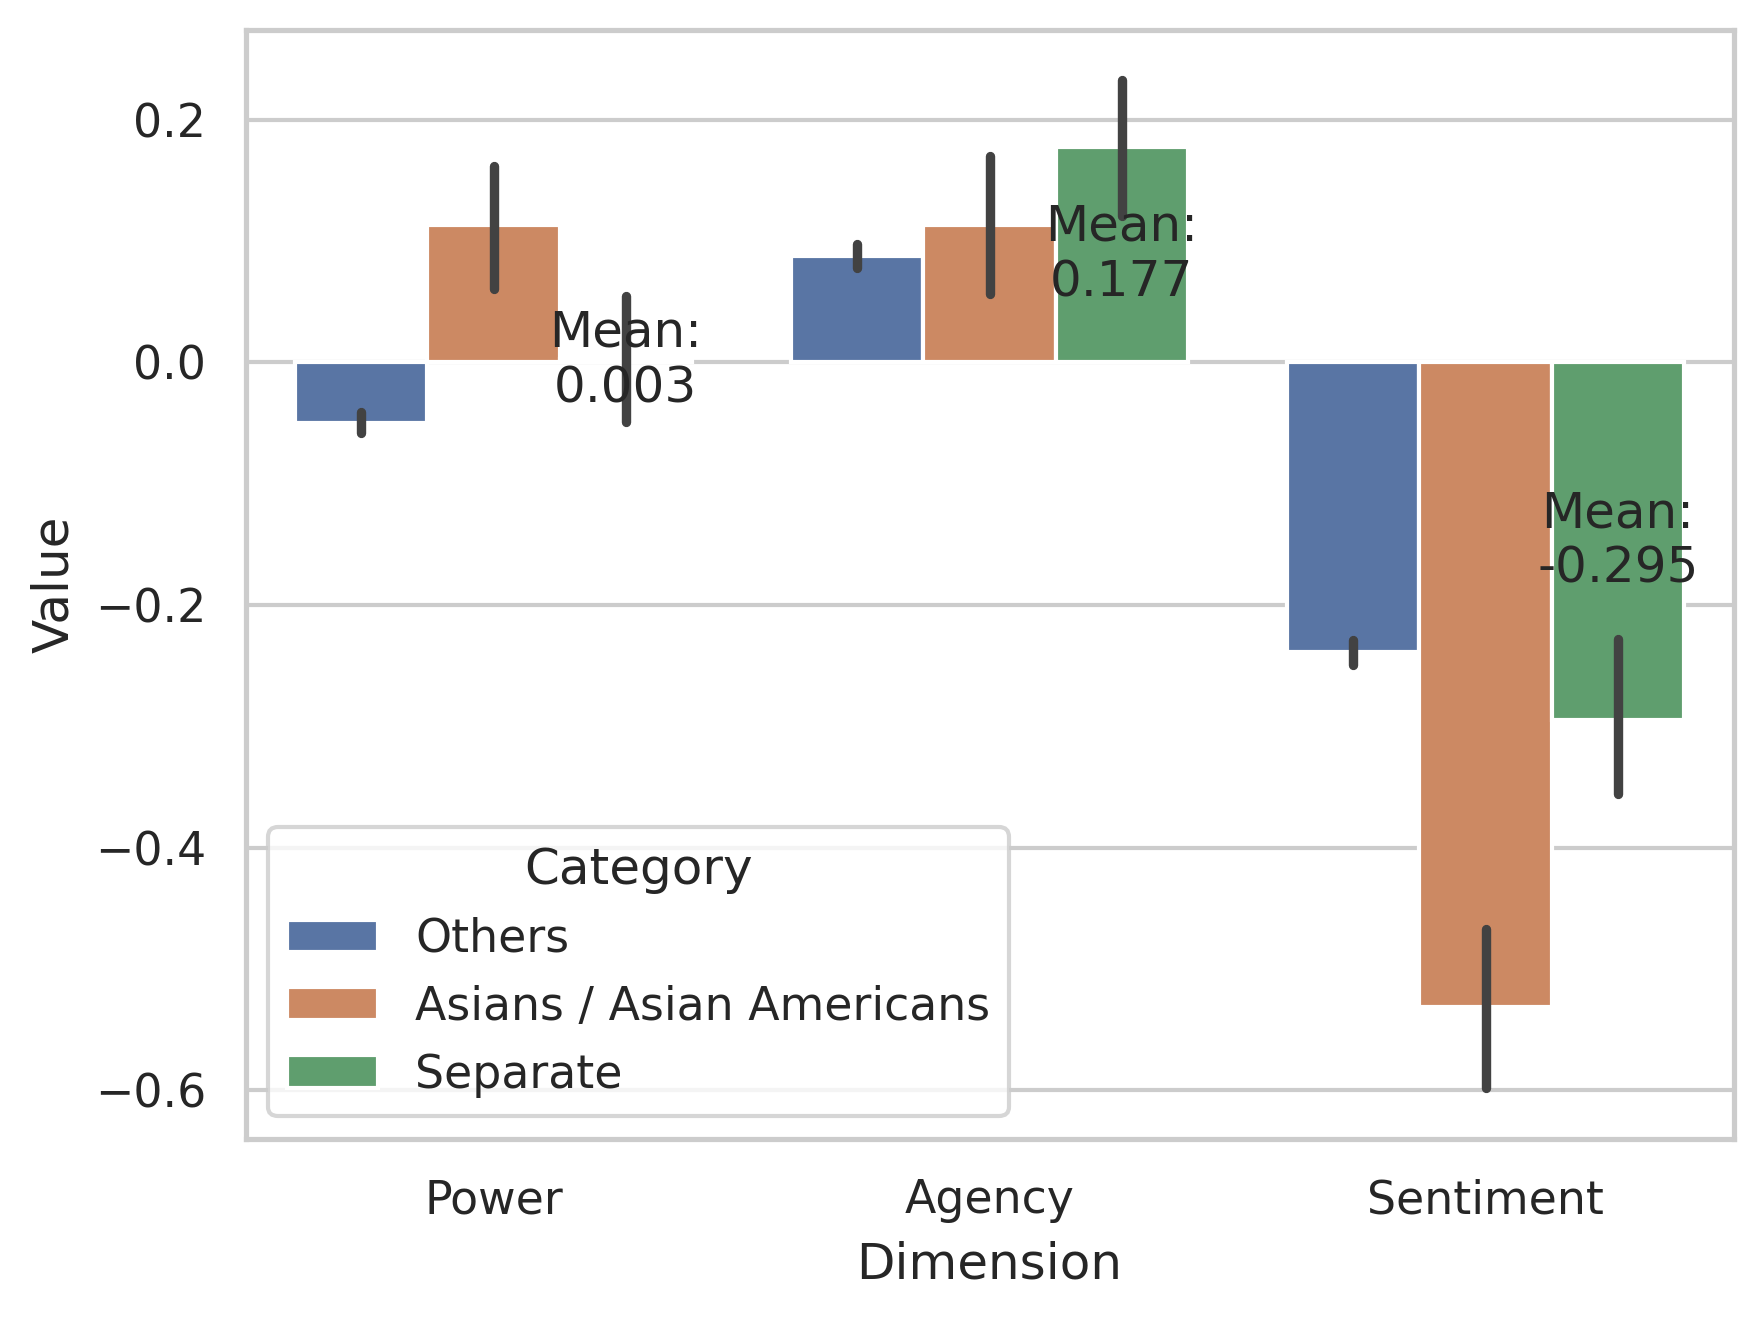

In [67]:
temp_df, _, _ = calculate_scores(['results/war_people_descriptors.csv'], agencies, powers, \
                                                    conn_lexicon, conn_vocab, input_stats=[verb_means, verb_stds], 
                                       separate_cat=['german'])
ax = sns.barplot(x='Dimension', y='Value', hue='Category', data=temp_df)
ax.bar_label(ax.containers[-1], fmt='Mean:\n%.3f', label_type='center')
lower = [min(line.get_ydata()) for line in ax.lines]
upper = [max(line.get_ydata()) for line in ax.lines]
# print confidene intervals for the last green bar with Mean = -0.295 on the far right to report in paper.
print("Confidence intervals:", lower[-1], upper[-1])
plt.show()